In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
auc = tf.keras.metrics.AUC()


# Initialize rng
rng = np.random.default_rng(2022)

In [5]:
batch_size = 32                  # This is a tunable hyperparameter
shape = (128, 128)               # note we are reducing the size of the image

 # Note: you will use 'grayscale' images for your own model
# but you might need to switch to 'rgb' for pretrained models because they are trained on ImageNet which has only RGB images
data_dir = '/content/drive/MyDrive/split_archive/'
train_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'train'),
                                                       label_mode='int',
                                                       seed=rng.integers(500000),
                                                       image_size=shape,
                                                       color_mode='grayscale', # Note: you will use 'grayscale' images for your own model
                                                       batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'val'),
                                                    label_mode='int',
                                                     seed=rng.integers(500000),
                                                     image_size=shape,
                                                     color_mode='grayscale',
                                                     batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'test'),
                                                    label_mode='int',
                                                      seed=rng.integers(500000),
                                                      image_size=shape,
                                                      color_mode='grayscale',
                                                      batch_size=batch_size)

Found 3954 files belonging to 2 classes.
Found 841 files belonging to 2 classes.
Found 844 files belonging to 2 classes.


In [4]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 1)
(32,)


# Start your solution below

In [4]:
def summarize_diagnostics(history, metric_names=['loss', 'auc', 'accuracy']):
    fig, ax = plt.subplots(1,3, figsize=(30, 10))
    # plot loss
    ax[0].set_title('Loss Curves', fontsize=20)
    ax[0].plot(history.history[metric_names[0]], label='train')
    ax[0].plot(history.history['val_' + metric_names[0]], label='val')
    ax[0].set_xlabel('Epochs', fontsize=15)
    ax[0].set_ylabel('Loss', fontsize=15)
    ax[0].legend(fontsize=15)

    # plot AUC
    ax[1].set_title('Classification AUC', fontsize=20)
    ax[1].plot(history.history[metric_names[1]], label='train')
    ax[1].plot(history.history['val_' + metric_names[1]], label='val')
    ax[1].set_xlabel('Epochs', fontsize=15)
    ax[1].set_ylabel('AUROC', fontsize=15)
    ax[1].legend(fontsize=15)

    # plot accuracy
    ax[2].set_title('Classification accuracy', fontsize=20)
    ax[2].plot(history.history[metric_names[2]], label='train')
    ax[2].plot(history.history['val_' + metric_names[2]], label='val')
    ax[2].set_xlabel('Epochs', fontsize=15)
    ax[2].set_ylabel('Accuracy', fontsize=15)
    ax[2].legend(fontsize=15)


# fist model

In [26]:
# 1st
input_size = (128, 128, 1)

learning_rate = 0.001
dropout_rate = 0.1
filter_size = 30
kernel_size_1 = (2, 2)
kernel_size_2 = (3, 3)

# Create a Sequential model
model = keras.Sequential()

model.add(layers.Conv2D( filter_size, kernel_size = kernel_size_1, activation='relu', padding = 'valid', input_shape = input_size))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D( filter_size, kernel_size = kernel_size_2, activation='relu', padding = 'same', input_shape = input_size))
model.add(layers.MaxPooling2D(pool_size=(3, 3)))

model.add(layers.Dropout(dropout_rate))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification, so using sigmoid activation
print(model.summary())

# Compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy',auc])


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 127, 127, 30)      150       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 63, 63, 30)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 63, 63, 30)        8130      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 21, 21, 30)        0         
 ng2D)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 21, 21, 30)        0         
                                                                 
 flatten_10 (Flatten)        (None, 13230)           

In [27]:
# early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10,
                   restore_best_weights=True)
history = model.fit(train_ds,
                        epochs=25,
                        batch_size=64,
                        validation_data=val_ds,
                        verbose=1,
                        callbacks=[es])

Epoch 1/25
124/124 [==============================] - 14s 99ms/step - loss: 26.7066 - accuracy: 0.5169 - auc: 0.5209 - val_loss: 0.7135 - val_accuracy: 0.5458 - val_auc: 0.5086
Epoch 2/25
124/124 [==============================] - 13s 100ms/step - loss: 0.6634 - accuracy: 0.5926 - auc: 0.6288 - val_loss: 0.7061 - val_accuracy: 0.5672 - val_auc: 0.5393
Epoch 3/25
124/124 [==============================] - 13s 97ms/step - loss: 0.6275 - accuracy: 0.6340 - auc: 0.6830 - val_loss: 0.7290 - val_accuracy: 0.5541 - val_auc: 0.5474
Epoch 4/25
124/124 [==============================] - 13s 97ms/step - loss: 0.5904 - accuracy: 0.6651 - auc: 0.7327 - val_loss: 0.8132 - val_accuracy: 0.4970 - val_auc: 0.5318
Epoch 5/25
124/124 [==============================] - 13s 97ms/step - loss: 0.5576 - accuracy: 0.6889 - auc: 0.7689 - val_loss: 0.8129 - val_accuracy: 0.5612 - val_auc: 0.5382
Epoch 6/25
124/124 [==============================] - 13s 97ms/step - loss: 0.4947 - accuracy: 0.7382 - auc: 0.8290 - 

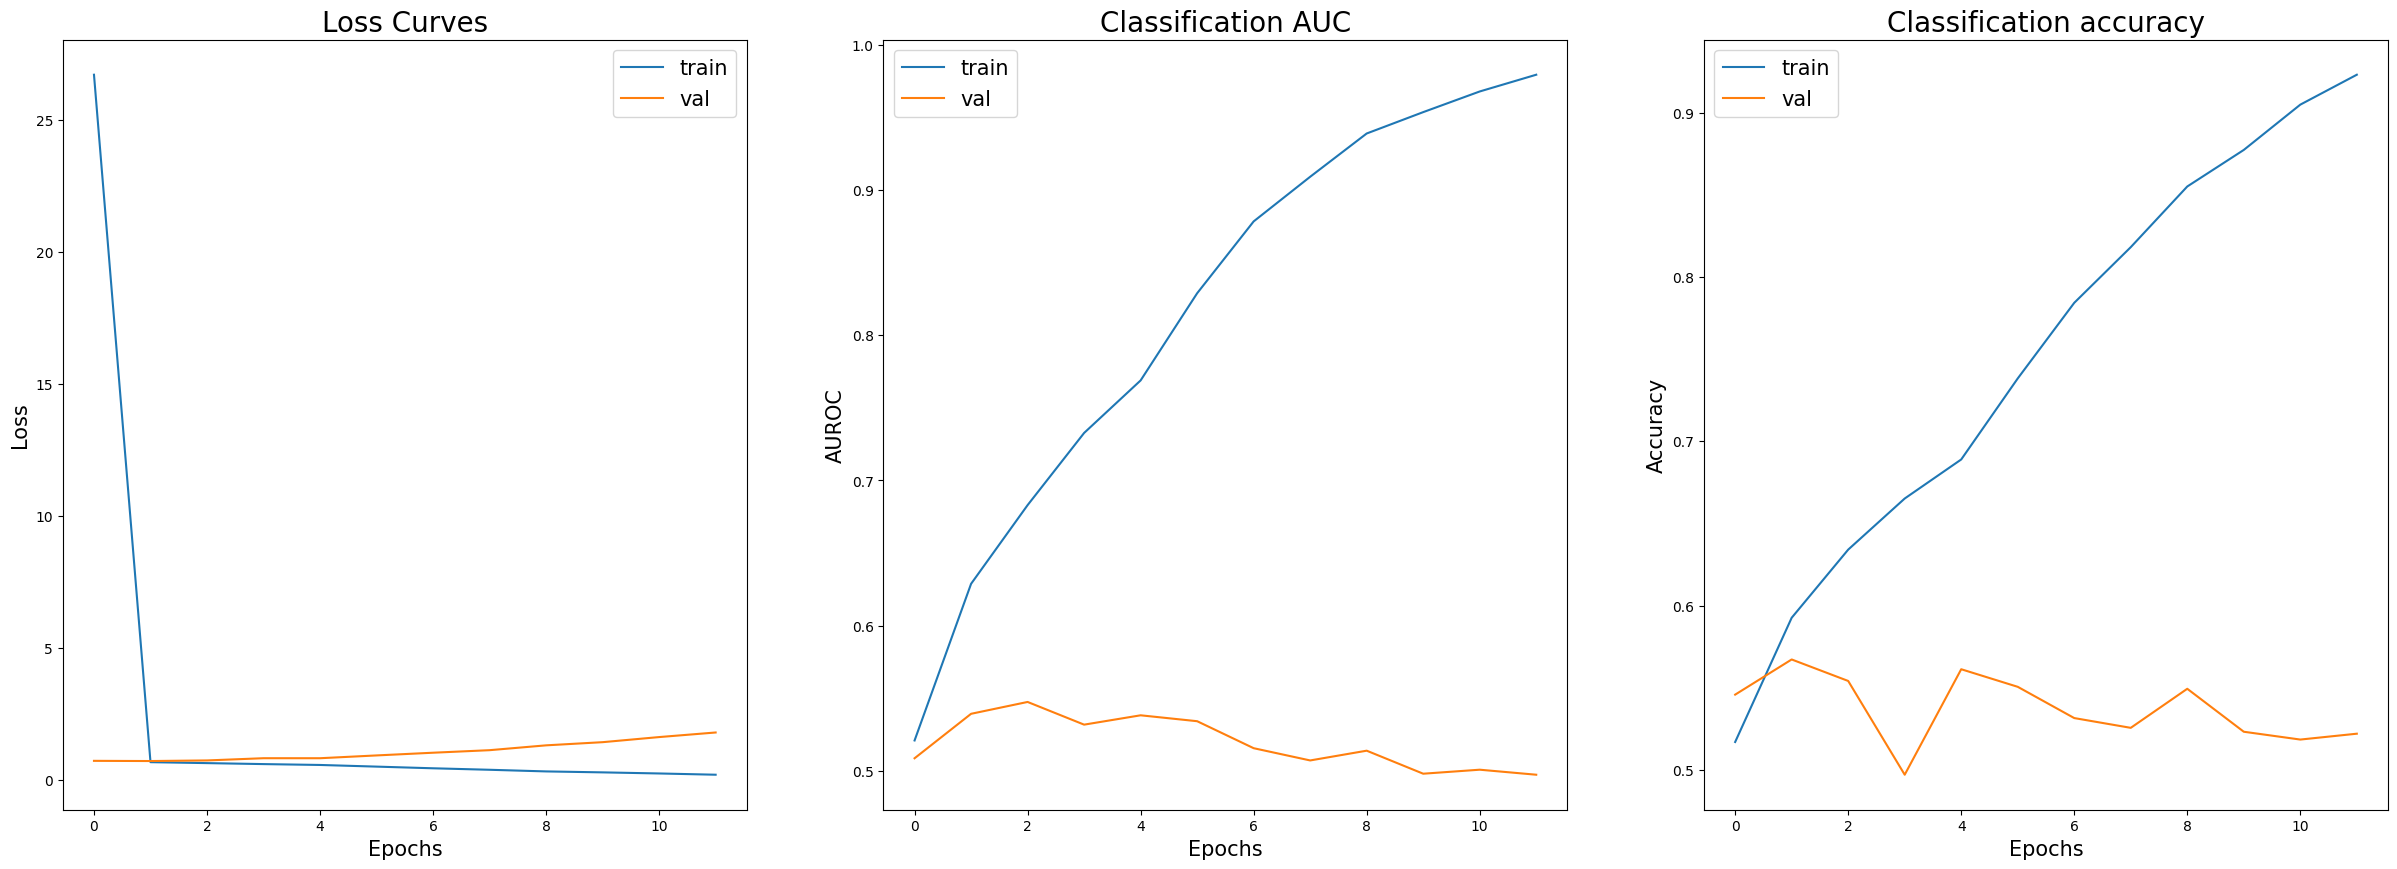

In [30]:
summarize_diagnostics(history)

In [33]:
testLoss, testAcc, testAUC = model.evaluate(test_ds, verbose=1)
print('Test loss:{:0.5f}'.format(testLoss))
print('Test accuracy:{:0.4f}'.format(testAcc))
print('Test AUC:{:0.4f}'.format(testAUC))

27/27 [==============================] - 2s 56ms/step - loss: 0.7180 - accuracy: 0.5581 - auc: 0.5466
Test loss:0.71799
Test accuracy:0.5581
Test AUC:0.5466


In [34]:
# 2nd
input_size = (128, 128, 1)

learning_rate = 0.001
dropout_rate = 0.2
filter_size = 30
kernel_size_1 = (3, 3)
kernel_size_2 = (4, 4)

# Create a Sequential model
model = keras.Sequential()

model.add(layers.Conv2D( filter_size, kernel_size = kernel_size_1, activation='relu', padding = 'valid', input_shape = input_size))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D( filter_size, kernel_size = kernel_size_2, activation='relu', padding = 'same', input_shape = input_size))
model.add(layers.MaxPooling2D(pool_size=(3, 3)))

model.add(layers.Dropout(dropout_rate))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification, so using sigmoid activation
print(model.summary())

# Compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy',auc])


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 126, 126, 30)      300       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 63, 63, 30)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 63, 63, 30)        14430     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 21, 21, 30)        0         
 ng2D)                                                           
                                                                 
 dropout_11 (Dropout)        (None, 21, 21, 30)        0         
                                                                 
 flatten_11 (Flatten)        (None, 13230)           

In [35]:
# early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10,
                   restore_best_weights=True)
history = model.fit(train_ds,
                        epochs=25,
                        batch_size=64,
                        validation_data=val_ds,
                        verbose=1,
                        callbacks=[es])

Epoch 1/25
124/124 [==============================] - 15s 101ms/step - loss: 17.7073 - accuracy: 0.5235 - auc: 0.5198 - val_loss: 0.6850 - val_accuracy: 0.5351 - val_auc: 0.5670
Epoch 2/25
124/124 [==============================] - 13s 101ms/step - loss: 0.6713 - accuracy: 0.5759 - auc: 0.5986 - val_loss: 0.6856 - val_accuracy: 0.5589 - val_auc: 0.5655
Epoch 3/25
124/124 [==============================] - 13s 101ms/step - loss: 0.6468 - accuracy: 0.6136 - auc: 0.6455 - val_loss: 0.6971 - val_accuracy: 0.5553 - val_auc: 0.5501
Epoch 4/25
124/124 [==============================] - 13s 100ms/step - loss: 0.6137 - accuracy: 0.6388 - auc: 0.6967 - val_loss: 0.7414 - val_accuracy: 0.5422 - val_auc: 0.5197
Epoch 5/25
124/124 [==============================] - 13s 97ms/step - loss: 0.5790 - accuracy: 0.6743 - auc: 0.7398 - val_loss: 0.7943 - val_accuracy: 0.5493 - val_auc: 0.5337
Epoch 6/25
124/124 [==============================] - 13s 95ms/step - loss: 0.5288 - accuracy: 0.7152 - auc: 0.7943

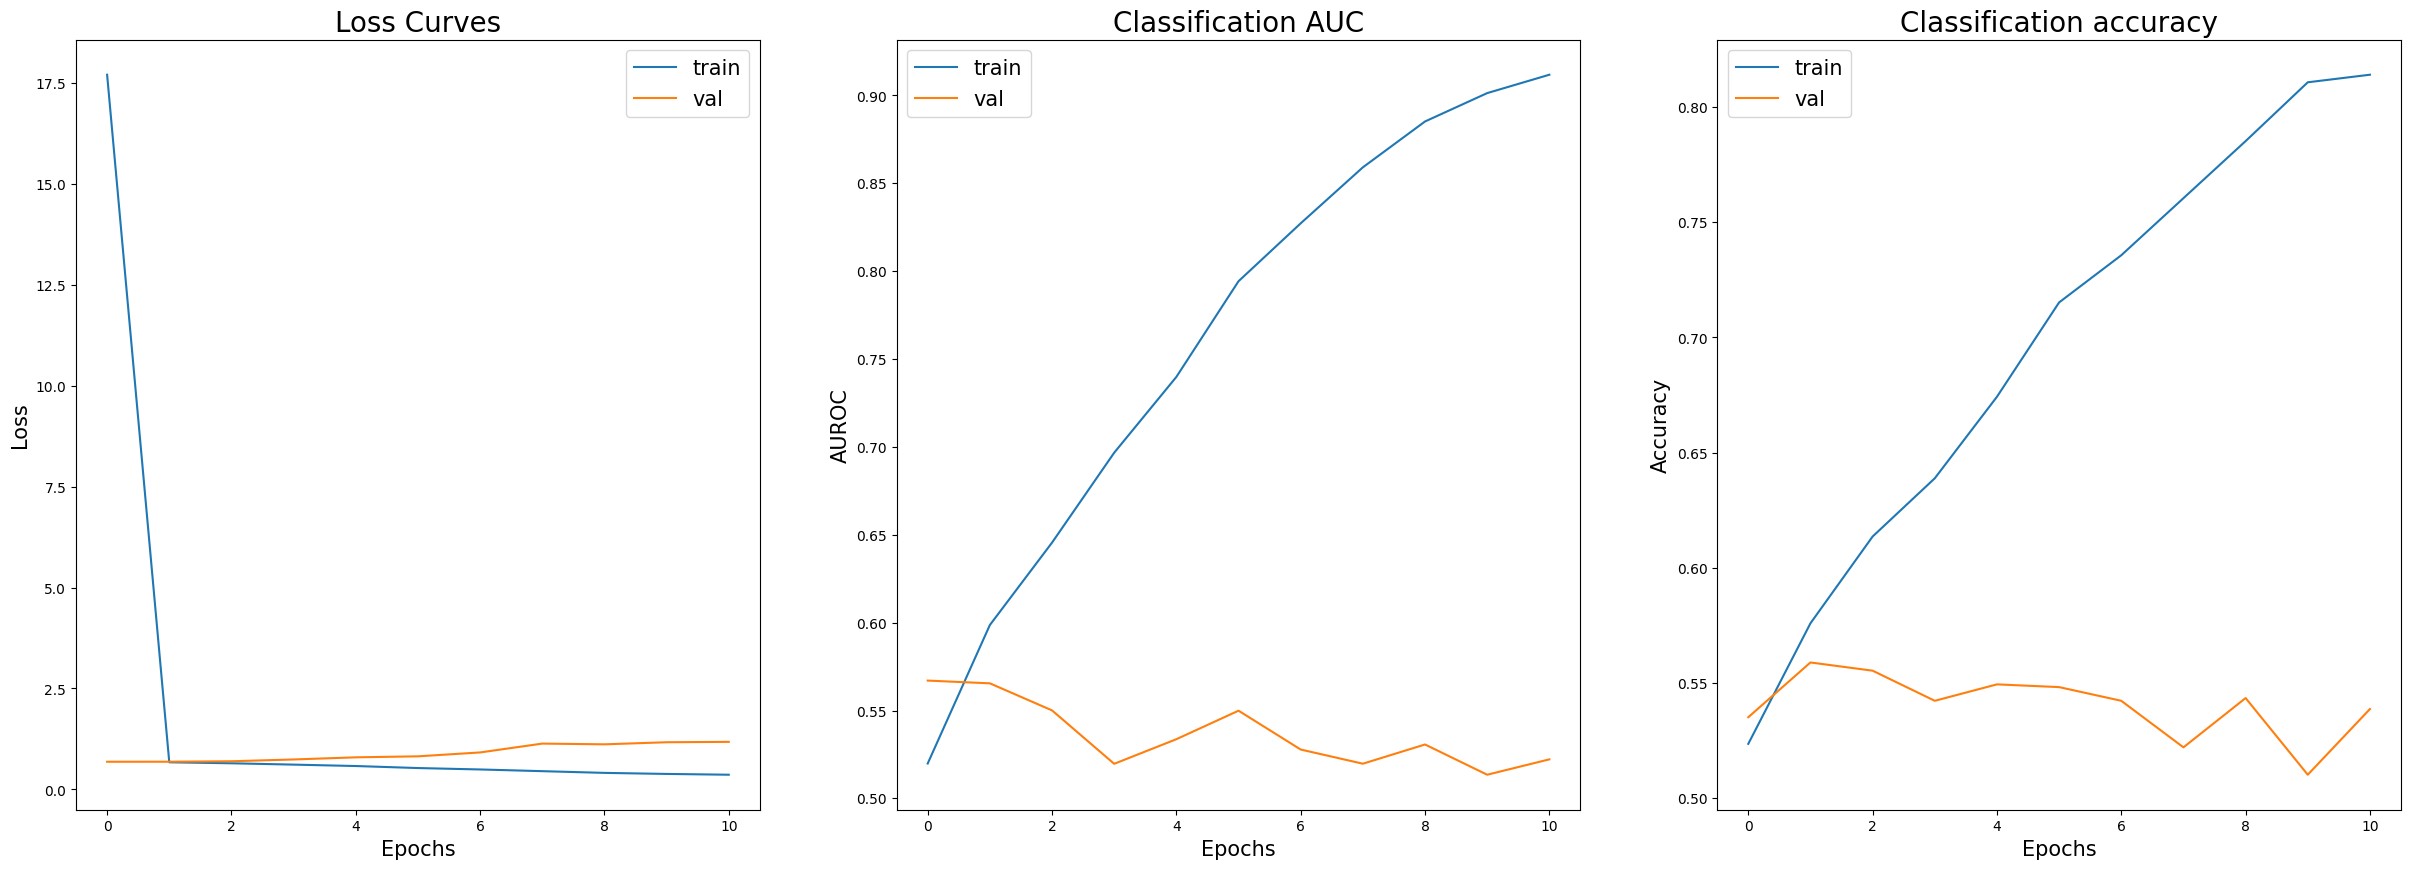

In [36]:
summarize_diagnostics(history)


In [37]:
testLoss, testAcc, testAUC = model.evaluate(test_ds, verbose=1)
print('Test loss:{:0.5f}'.format(testLoss))
print('Test accuracy:{:0.4f}'.format(testAcc))
print('Test AUC:{:0.4f}'.format(testAUC))

27/27 [==============================] - 2s 57ms/step - loss: 0.6892 - accuracy: 0.5427 - auc: 0.5300
Test loss:0.68922
Test accuracy:0.5427
Test AUC:0.5300


In [39]:
# 3rd
input_size = (128, 128, 1)

learning_rate = 0.001
dropout_rate = 0.3
filter_size = 30
kernel_size_1 = (4, 4)
kernel_size_2 = (5, 5)

# Create a Sequential model
model = keras.Sequential()

model.add(layers.Conv2D( filter_size, kernel_size = kernel_size_1, activation='relu', padding = 'valid', input_shape = input_size))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D( filter_size, kernel_size = kernel_size_2, activation='relu', padding = 'same', input_shape = input_size))
model.add(layers.MaxPooling2D(pool_size=(3, 3)))

model.add(layers.Dropout(dropout_rate))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification, so using sigmoid activation
print(model.summary())

# Compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy',auc])



Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 125, 125, 30)      510       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 62, 62, 30)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 62, 62, 30)        22530     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 20, 20, 30)        0         
 ng2D)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 20, 20, 30)        0         
                                                                 
 flatten_13 (Flatten)        (None, 12000)           

In [40]:
# early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10,
                   restore_best_weights=True)
history = model.fit(train_ds,
                        epochs=25,
                        batch_size=64,
                        validation_data=val_ds,
                        verbose=1,
                        callbacks=[es])

Epoch 1/25
124/124 [==============================] - 15s 100ms/step - loss: 6.2623 - accuracy: 0.5278 - auc: 0.5063 - val_loss: 0.6878 - val_accuracy: 0.5493 - val_auc: 0.4898
Epoch 2/25
124/124 [==============================] - 14s 106ms/step - loss: 0.6811 - accuracy: 0.5615 - auc: 0.5466 - val_loss: 0.6878 - val_accuracy: 0.5434 - val_auc: 0.5255
Epoch 3/25
124/124 [==============================] - 13s 99ms/step - loss: 0.6693 - accuracy: 0.5797 - auc: 0.5727 - val_loss: 0.7021 - val_accuracy: 0.5303 - val_auc: 0.5170
Epoch 4/25
124/124 [==============================] - 13s 97ms/step - loss: 0.6518 - accuracy: 0.5989 - auc: 0.6242 - val_loss: 0.7154 - val_accuracy: 0.5339 - val_auc: 0.5279
Epoch 5/25
124/124 [==============================] - 13s 97ms/step - loss: 0.6347 - accuracy: 0.6082 - auc: 0.6479 - val_loss: 0.7350 - val_accuracy: 0.5351 - val_auc: 0.5346
Epoch 6/25
124/124 [==============================] - 13s 101ms/step - loss: 0.6232 - accuracy: 0.6300 - auc: 0.6749 -

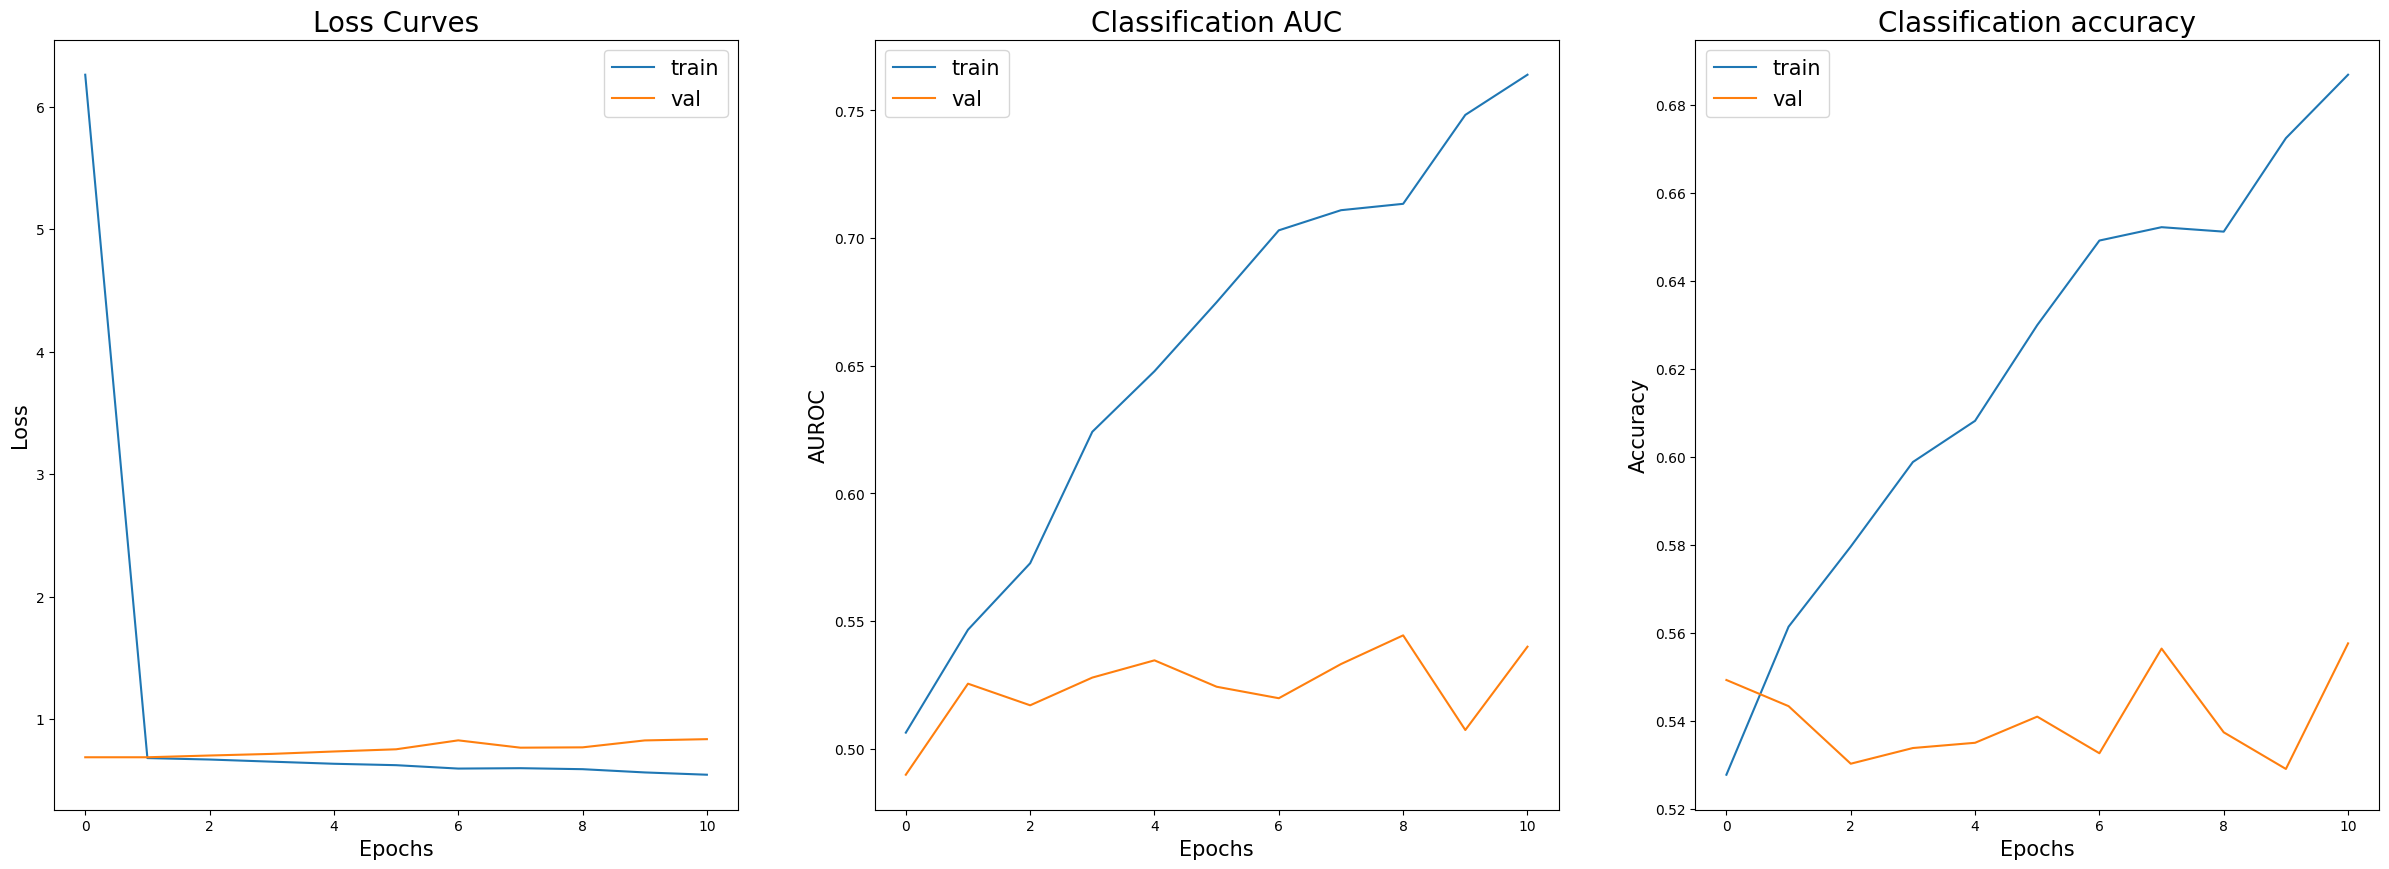

In [41]:
summarize_diagnostics(history)


In [42]:
testLoss, testAcc, testAUC = model.evaluate(test_ds, verbose=1)
print('Test loss:{:0.5f}'.format(testLoss))
print('Test accuracy:{:0.4f}'.format(testAcc))
print('Test AUC:{:0.4f}'.format(testAUC))

27/27 [==============================] - 2s 62ms/step - loss: 0.6899 - accuracy: 0.5462 - auc: 0.5098
Test loss:0.68995
Test accuracy:0.5462
Test AUC:0.5098


In [43]:
# 4rd
input_size = (128, 128, 1)

learning_rate = 0.001
dropout_rate = 0.4
filter_size = 30
kernel_size_1 = (5, 5)
kernel_size_2 = (6, 6)

# Create a Sequential model
model = keras.Sequential()

model.add(layers.Conv2D( filter_size, kernel_size = kernel_size_1, activation='relu', padding = 'valid', input_shape = input_size))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D( filter_size, kernel_size = kernel_size_2, activation='relu', padding = 'same', input_shape = input_size))
model.add(layers.MaxPooling2D(pool_size=(3, 3)))

model.add(layers.Dropout(dropout_rate))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification, so using sigmoid activation
print(model.summary())

# Compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy',auc])



Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 124, 124, 30)      780       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 62, 62, 30)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 62, 62, 30)        32430     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 20, 20, 30)        0         
 ng2D)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 20, 20, 30)        0         
                                                                 
 flatten_14 (Flatten)        (None, 12000)           

In [44]:
# early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10,
                   restore_best_weights=True)
history = model.fit(train_ds,
                        epochs=25,
                        batch_size=64,
                        validation_data=val_ds,
                        verbose=1,
                        callbacks=[es])

Epoch 1/25
124/124 [==============================] - 15s 101ms/step - loss: 4.9130 - accuracy: 0.5357 - auc: 0.4967 - val_loss: 0.6870 - val_accuracy: 0.5482 - val_auc: 0.5171
Epoch 2/25
124/124 [==============================] - 13s 103ms/step - loss: 0.6885 - accuracy: 0.5541 - auc: 0.5146 - val_loss: 0.6868 - val_accuracy: 0.5529 - val_auc: 0.5038
Epoch 3/25
124/124 [==============================] - 13s 100ms/step - loss: 0.6847 - accuracy: 0.5574 - auc: 0.5518 - val_loss: 0.7013 - val_accuracy: 0.5256 - val_auc: 0.4970
Epoch 4/25
124/124 [==============================] - 13s 98ms/step - loss: 0.6764 - accuracy: 0.5685 - auc: 0.5550 - val_loss: 0.6960 - val_accuracy: 0.5410 - val_auc: 0.5025
Epoch 5/25
124/124 [==============================] - 13s 97ms/step - loss: 0.6720 - accuracy: 0.5716 - auc: 0.5713 - val_loss: 0.6978 - val_accuracy: 0.5339 - val_auc: 0.5141
Epoch 6/25
124/124 [==============================] - 13s 99ms/step - loss: 0.6629 - accuracy: 0.5873 - auc: 0.5904 -

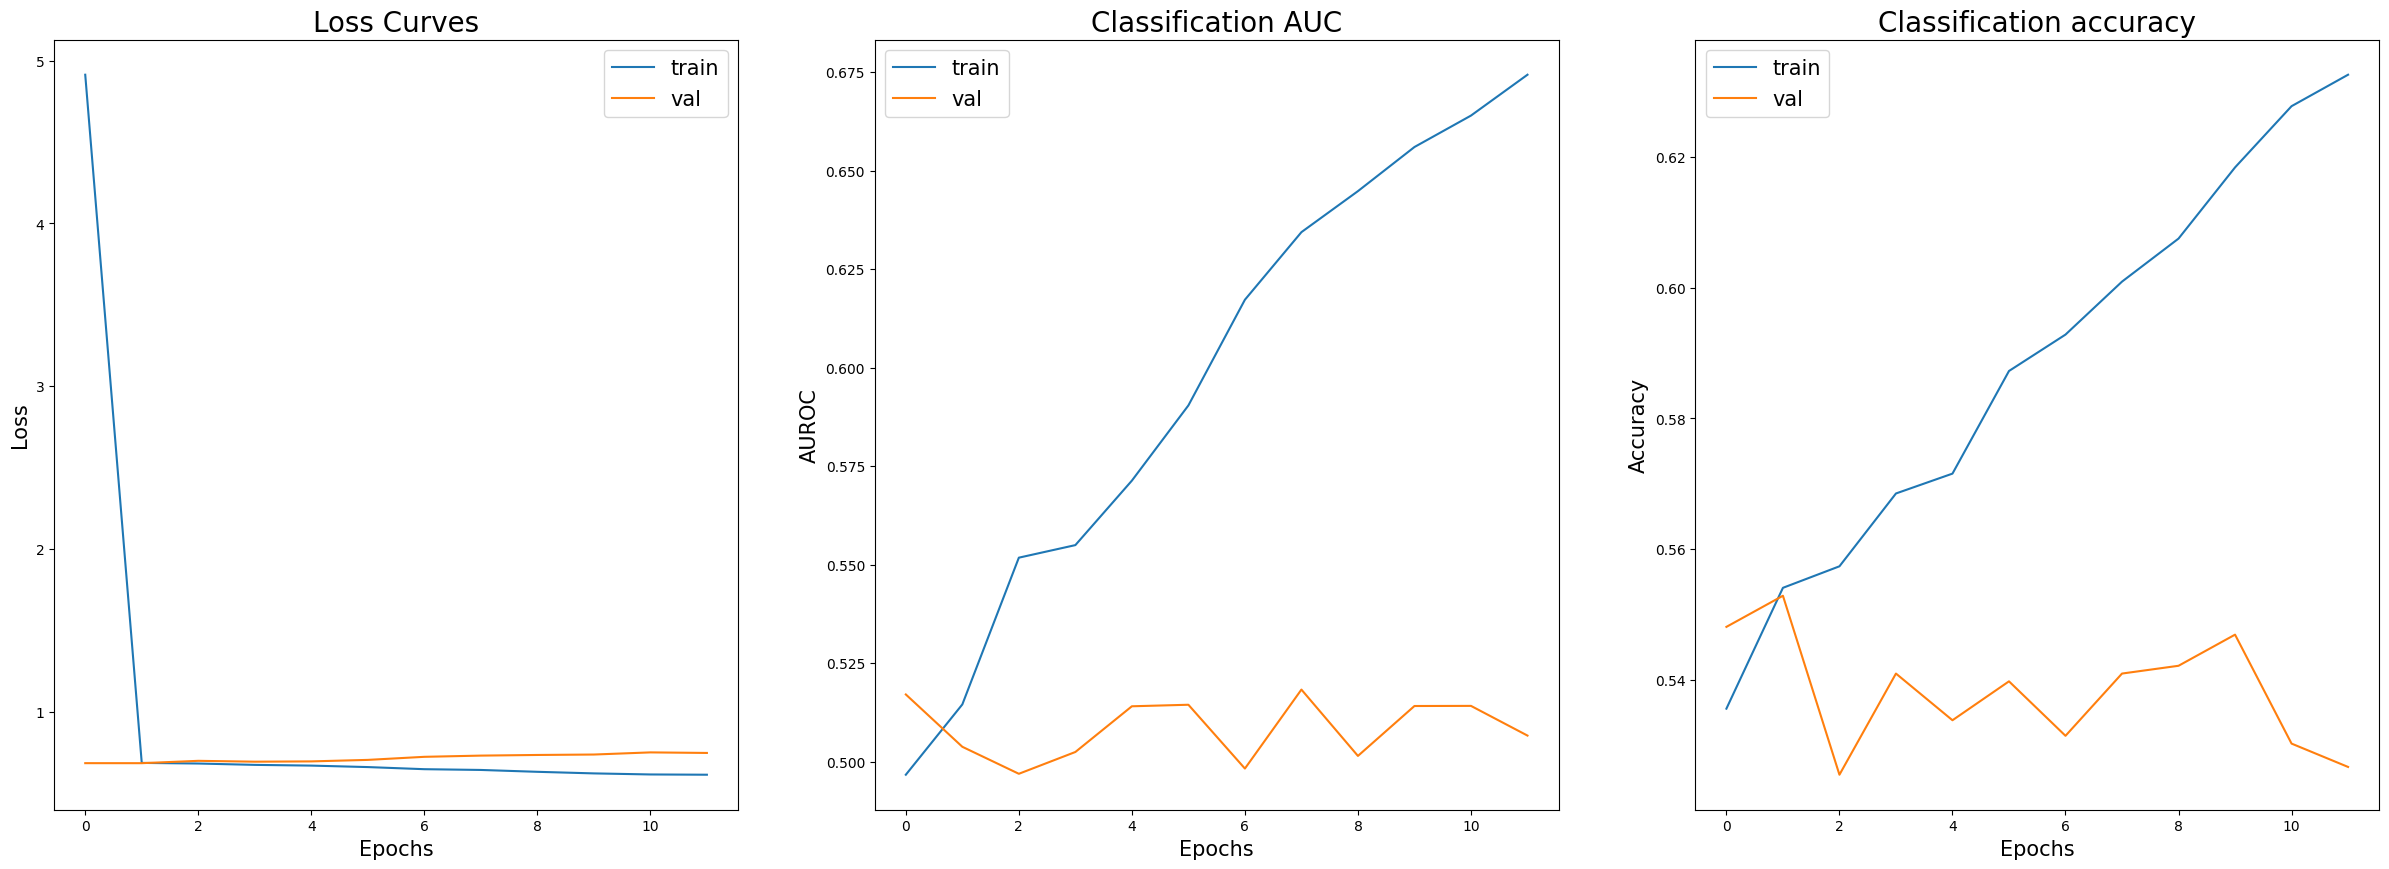

In [45]:
summarize_diagnostics(history)


In [46]:
testLoss, testAcc, testAUC = model.evaluate(test_ds, verbose=1)
print('Test loss:{:0.5f}'.format(testLoss))
print('Test accuracy:{:0.4f}'.format(testAcc))
print('Test AUC:{:0.4f}'.format(testAUC))

27/27 [==============================] - 2s 58ms/step - loss: 0.6967 - accuracy: 0.5462 - auc: 0.5250
Test loss:0.69671
Test accuracy:0.5462
Test AUC:0.5250


In [47]:
# 5rd
input_size = (128, 128, 1)

learning_rate = 0.001
dropout_rate = 0.5
filter_size = 30
kernel_size_1 = (6, 6)
kernel_size_2 = (7, 7)

# Create a Sequential model
model = keras.Sequential()

model.add(layers.Conv2D( filter_size, kernel_size = kernel_size_1, activation='relu', padding = 'valid', input_shape = input_size))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D( filter_size, kernel_size = kernel_size_2, activation='relu', padding = 'same', input_shape = input_size))
model.add(layers.MaxPooling2D(pool_size=(3, 3)))

model.add(layers.Dropout(dropout_rate))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification, so using sigmoid activation
print(model.summary())

# Compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy',auc])



Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 123, 123, 30)      1110      
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 61, 61, 30)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 61, 61, 30)        44130     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 20, 20, 30)        0         
 ng2D)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 20, 20, 30)        0         
                                                                 
 flatten_15 (Flatten)        (None, 12000)           

In [48]:
# early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10,
                   restore_best_weights=True)
history = model.fit(train_ds,
                        epochs=25,
                        batch_size=64,
                        validation_data=val_ds,
                        verbose=1,
                        callbacks=[es])

Epoch 1/25
124/124 [==============================] - 15s 101ms/step - loss: 3.2353 - accuracy: 0.5379 - auc: 0.5033 - val_loss: 0.6895 - val_accuracy: 0.5422 - val_auc: 0.5070
Epoch 2/25
124/124 [==============================] - 13s 98ms/step - loss: 0.6869 - accuracy: 0.5516 - auc: 0.5189 - val_loss: 0.6895 - val_accuracy: 0.5363 - val_auc: 0.5108
Epoch 3/25
124/124 [==============================] - 13s 98ms/step - loss: 0.6829 - accuracy: 0.5597 - auc: 0.5362 - val_loss: 0.6865 - val_accuracy: 0.5529 - val_auc: 0.5106
Epoch 4/25
124/124 [==============================] - 13s 98ms/step - loss: 0.6789 - accuracy: 0.5695 - auc: 0.5446 - val_loss: 0.6915 - val_accuracy: 0.5279 - val_auc: 0.4962
Epoch 5/25
124/124 [==============================] - 13s 98ms/step - loss: 0.6747 - accuracy: 0.5738 - auc: 0.5528 - val_loss: 0.6985 - val_accuracy: 0.5303 - val_auc: 0.5037
Epoch 6/25
124/124 [==============================] - 13s 97ms/step - loss: 0.6687 - accuracy: 0.5688 - auc: 0.5660 - v

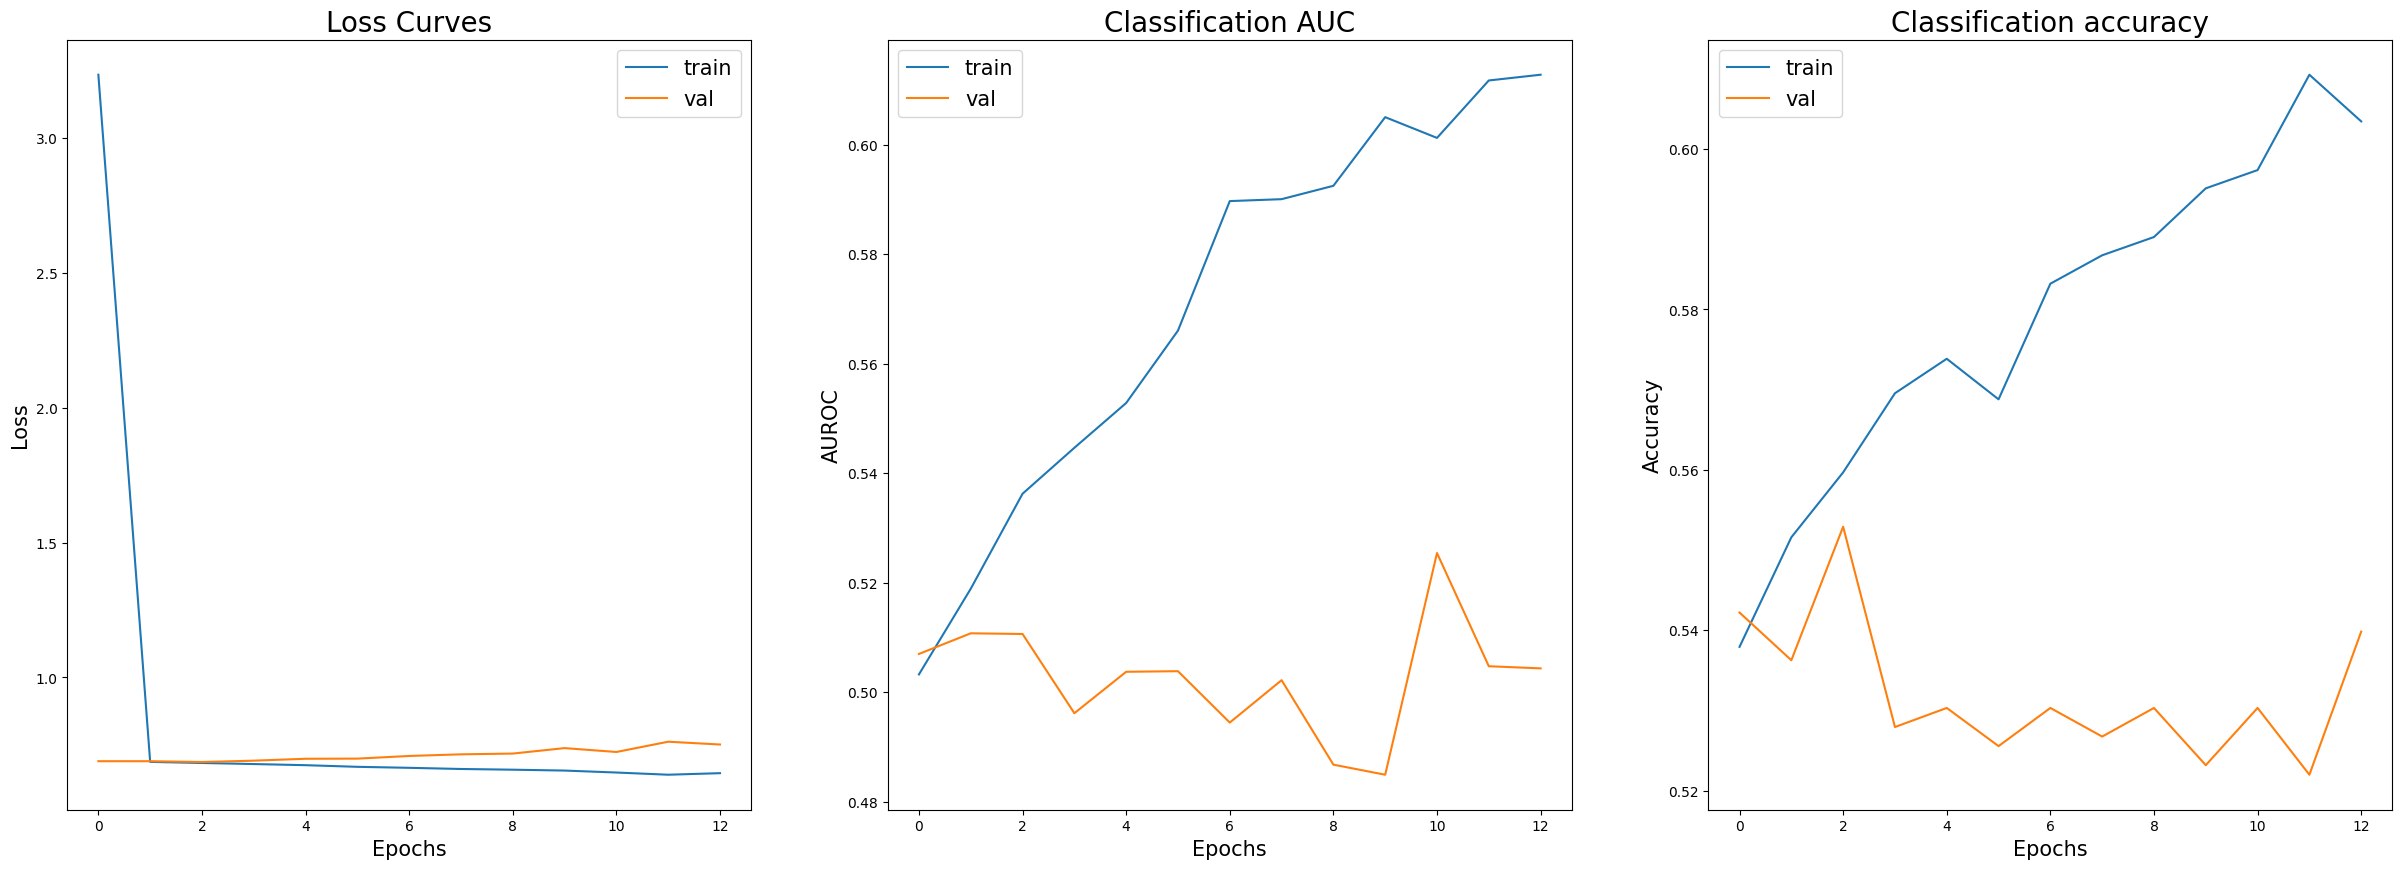

In [49]:
summarize_diagnostics(history)


In [50]:
testLoss, testAcc, testAUC = model.evaluate(test_ds, verbose=1)
print('Test loss:{:0.5f}'.format(testLoss))
print('Test accuracy:{:0.4f}'.format(testAcc))
print('Test AUC:{:0.4f}'.format(testAUC))

27/27 [==============================] - 3s 64ms/step - loss: 0.6988 - accuracy: 0.5427 - auc: 0.5206
Test loss:0.69875
Test accuracy:0.5427
Test AUC:0.5206


# second model


In [51]:
# 1
input_size = (128, 128, 1)

learning_rate = 0.001
dropout_rate = 0.5
filter_size = 30
kernel_size_1 = (3, 3)
kernel_size_2 = (3, 3)

up_sampling_1= (3, 3)
up_sampling_2= (3, 3)
# Create a Sequential model
model = keras.Sequential()

model.add(layers.Conv2D( filter_size, kernel_size = kernel_size_1, activation='relu', padding = 'valid', input_shape = input_size))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D( filter_size, kernel_size = kernel_size_2, activation='relu', padding = 'same', input_shape = input_size))
model.add(layers.MaxPooling2D(pool_size=(3, 3)))


model.add(layers.UpSampling2D(size=up_sampling_1)) # Upsample the feature maps
model.add(layers.UpSampling2D(size=up_sampling_1))

model.add(layers.Dropout(dropout_rate))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification, so using sigmoid activation
print(model.summary())

# Compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy',auc])



Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 126, 126, 30)      300       
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 63, 63, 30)        0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 63, 63, 30)        8130      
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 21, 21, 30)        0         
 ng2D)                                                           
                                                                 
 up_sampling2d (UpSampling2  (None, 63, 63, 30)        0         
 D)                                                              
                                                     

In [55]:
# early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10,
                   restore_best_weights=True)
history = model.fit(train_ds,
                        epochs=25,
                        batch_size=64,
                        validation_data=val_ds,
                        verbose=1,
                        callbacks=[es])

Epoch 1/25
124/124 [==============================] - 18s 141ms/step - loss: 0.4220 - accuracy: 0.7868 - auc: 0.8780 - val_loss: 1.3765 - val_accuracy: 0.5446 - val_auc: 0.5273
Epoch 2/25
124/124 [==============================] - 14s 106ms/step - loss: 0.4131 - accuracy: 0.7802 - auc: 0.8802 - val_loss: 1.4683 - val_accuracy: 0.5434 - val_auc: 0.5218
Epoch 3/25
124/124 [==============================] - 14s 104ms/step - loss: 0.4112 - accuracy: 0.7863 - auc: 0.8831 - val_loss: 1.6108 - val_accuracy: 0.5232 - val_auc: 0.5183
Epoch 4/25
124/124 [==============================] - 14s 104ms/step - loss: 0.3752 - accuracy: 0.8088 - auc: 0.9028 - val_loss: 1.6749 - val_accuracy: 0.5398 - val_auc: 0.5398
Epoch 5/25
124/124 [==============================] - 14s 104ms/step - loss: 0.3428 - accuracy: 0.8232 - auc: 0.9191 - val_loss: 1.8826 - val_accuracy: 0.5339 - val_auc: 0.5203
Epoch 6/25
124/124 [==============================] - 14s 104ms/step - loss: 0.3919 - accuracy: 0.8164 - auc: 0.907

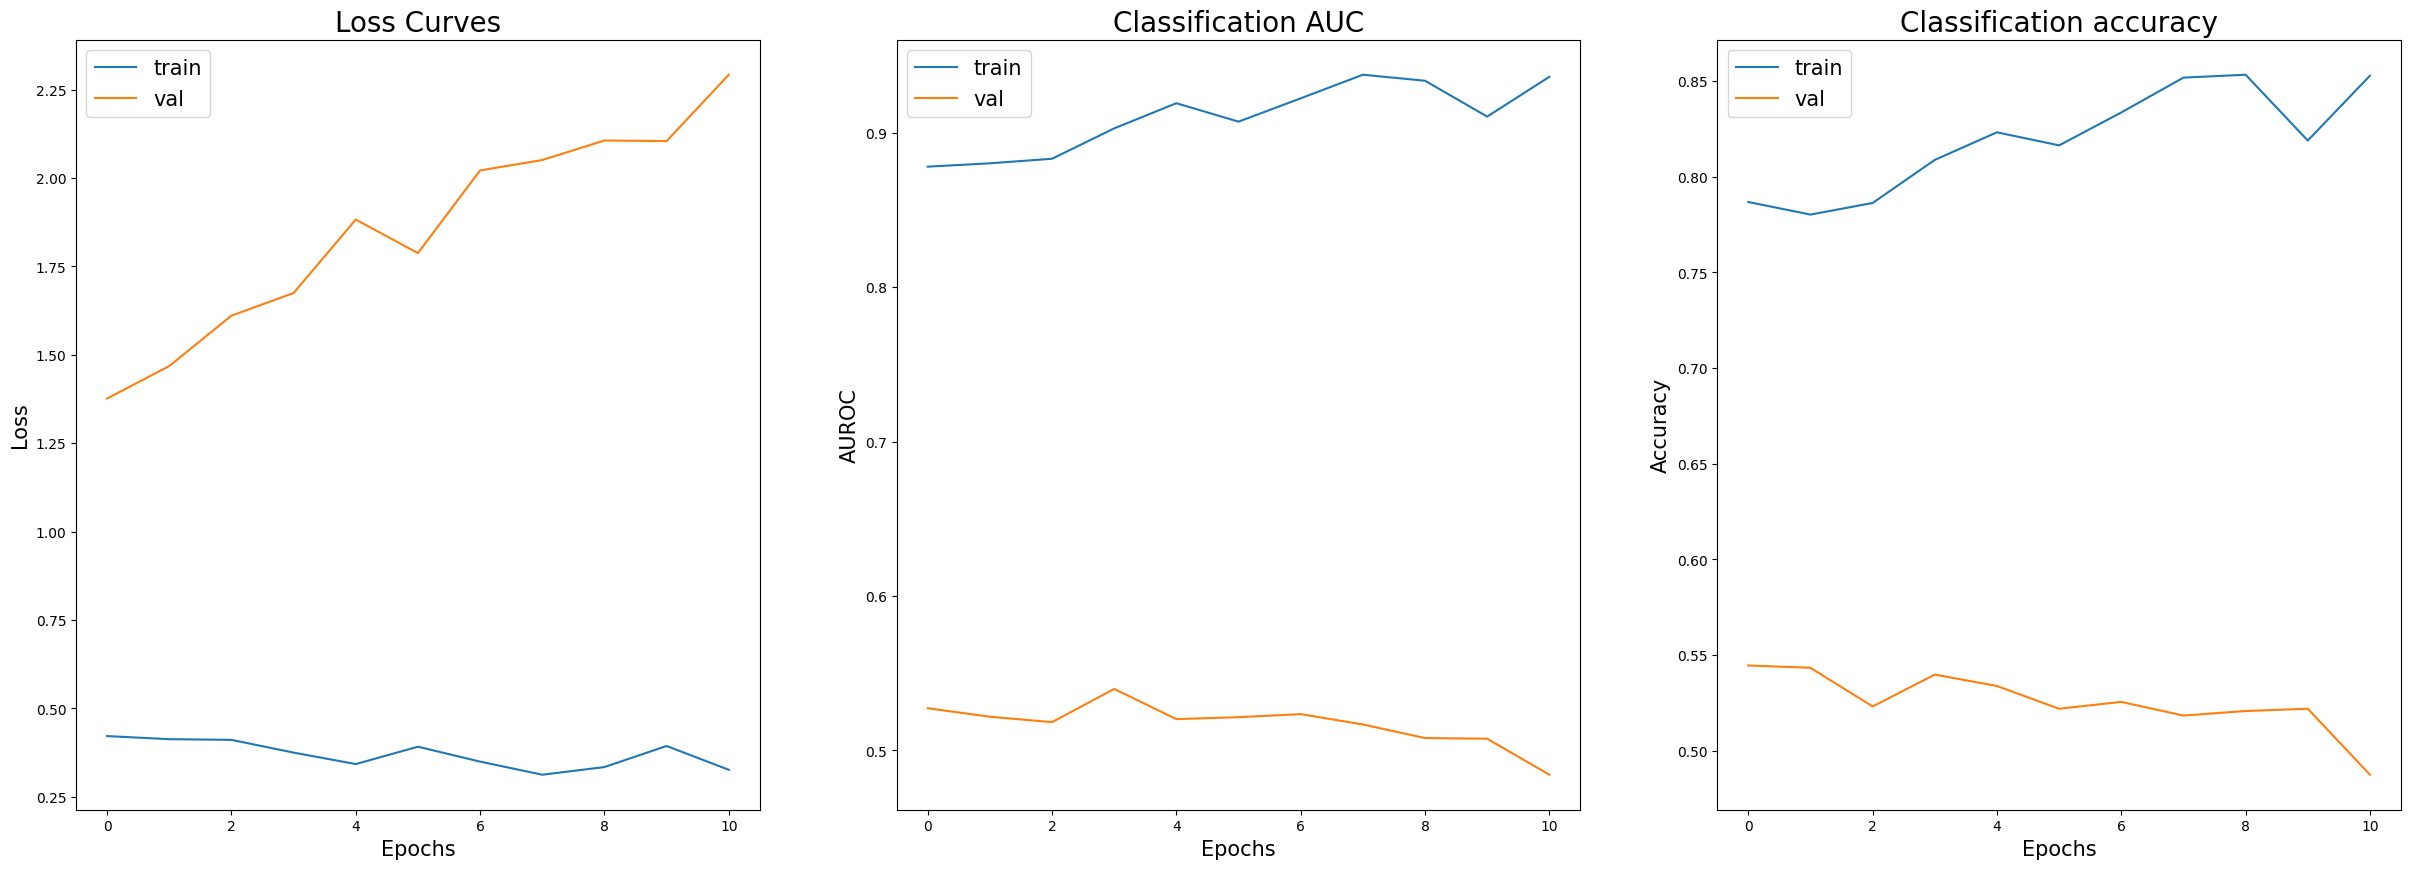

In [56]:
summarize_diagnostics(history)


In [57]:
testLoss, testAcc, testAUC = model.evaluate(test_ds, verbose=1)
print('Test loss:{:0.5f}'.format(testLoss))
print('Test accuracy:{:0.4f}'.format(testAcc))
print('Test AUC:{:0.4f}'.format(testAUC))

27/27 [==============================] - 3s 65ms/step - loss: 1.4761 - accuracy: 0.5308 - auc: 0.5193
Test loss:1.47615
Test accuracy:0.5308
Test AUC:0.5193


In [60]:
# 2
input_size = (128, 128, 1)

learning_rate = 0.001
dropout_rate = 0.5
filter_size = 30
kernel_size_1 = (3, 3)
kernel_size_2 = (3, 3)

up_sampling_1= (4, 4)
up_sampling_2= (4, 4)
# Create a Sequential model
model = keras.Sequential()

model.add(layers.Conv2D( filter_size, kernel_size = kernel_size_1, activation='relu', padding = 'valid', input_shape = input_size))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D( filter_size, kernel_size = kernel_size_2, activation='relu', padding = 'same', input_shape = input_size))
model.add(layers.MaxPooling2D(pool_size=(3, 3)))


model.add(layers.UpSampling2D(size=up_sampling_1)) # Upsample the feature maps
model.add(layers.UpSampling2D(size=up_sampling_1))

model.add(layers.Dropout(dropout_rate))

model.add(layers.Flatten())

model.add(layers.Dense(52, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification, so using sigmoid activation
print(model.summary())

# Compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy',auc])



Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 126, 126, 30)      300       
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 63, 63, 30)        0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 63, 63, 30)        8130      
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 21, 21, 30)        0         
 ng2D)                                                           
                                                                 
 up_sampling2d_6 (UpSamplin  (None, 84, 84, 30)        0         
 g2D)                                                            
                                                     

In [61]:
# early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10,
                   restore_best_weights=True)
history = model.fit(train_ds,
                        epochs=25,
                        batch_size=64,
                        validation_data=val_ds,
                        verbose=1,
                        callbacks=[es])

Epoch 1/25
124/124 [==============================] - 17s 113ms/step - loss: 1160.0927 - accuracy: 0.4894 - auc: 0.4993 - val_loss: 0.7654 - val_accuracy: 0.5434 - val_auc: 0.5006
Epoch 2/25
124/124 [==============================] - 14s 107ms/step - loss: 0.7116 - accuracy: 0.5496 - auc: 0.5058 - val_loss: 0.7603 - val_accuracy: 0.5434 - val_auc: 0.5019
Epoch 3/25
124/124 [==============================] - 13s 101ms/step - loss: 0.6858 - accuracy: 0.5506 - auc: 0.4955 - val_loss: 0.7644 - val_accuracy: 0.5446 - val_auc: 0.5032
Epoch 4/25
124/124 [==============================] - 13s 100ms/step - loss: 0.6861 - accuracy: 0.5536 - auc: 0.5065 - val_loss: 0.7603 - val_accuracy: 0.5482 - val_auc: 0.5039
Epoch 5/25
124/124 [==============================] - 14s 107ms/step - loss: 0.6836 - accuracy: 0.5539 - auc: 0.5085 - val_loss: 0.7587 - val_accuracy: 0.5493 - val_auc: 0.5071
Epoch 6/25
124/124 [==============================] - 14s 106ms/step - loss: 0.6800 - accuracy: 0.5544 - auc: 0.

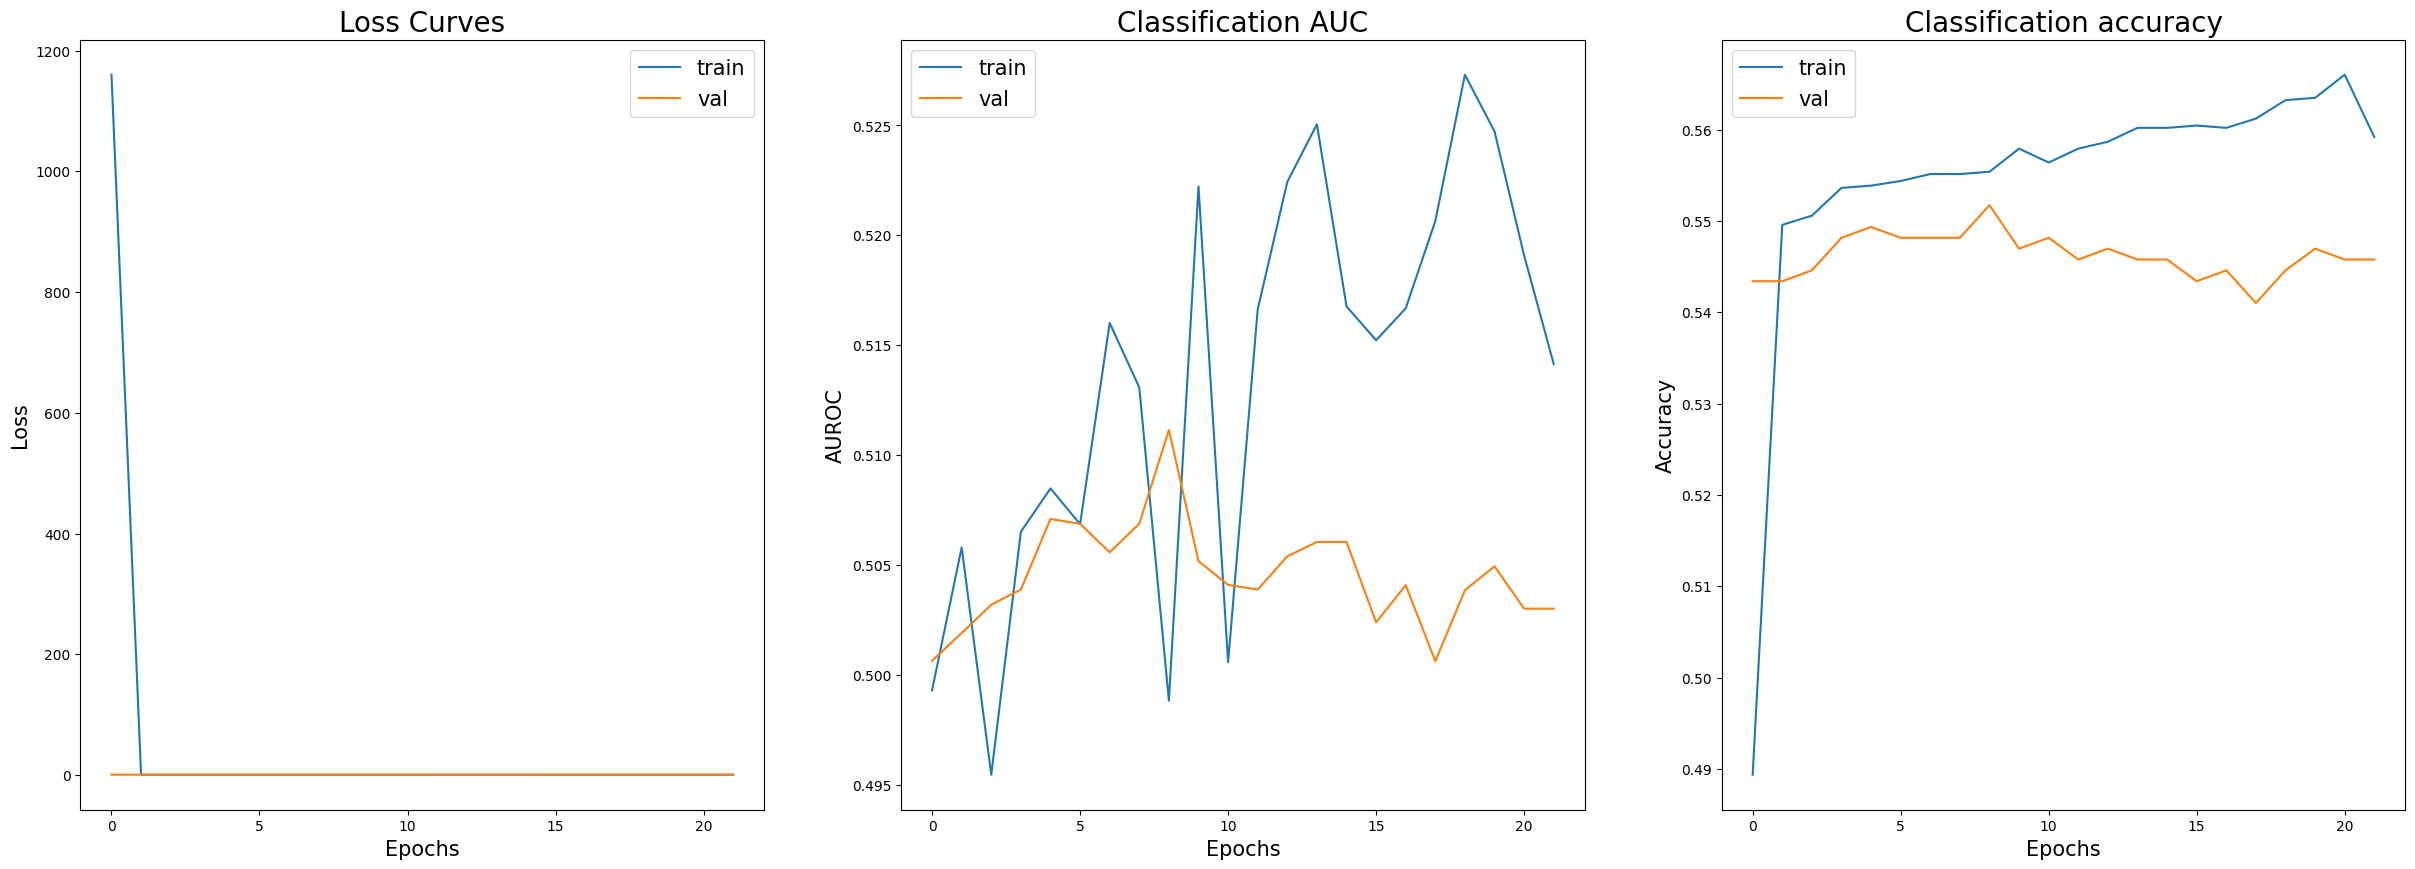

In [62]:
summarize_diagnostics(history)


In [63]:
testLoss, testAcc, testAUC = model.evaluate(test_ds, verbose=1)
print('Test loss:{:0.5f}'.format(testLoss))
print('Test accuracy:{:0.4f}'.format(testAcc))
print('Test AUC:{:0.4f}'.format(testAUC))

27/27 [==============================] - 2s 58ms/step - loss: 0.7194 - accuracy: 0.5427 - auc: 0.4922
Test loss:0.71940
Test accuracy:0.5427
Test AUC:0.4922


In [64]:
# 3rd
input_size = (128, 128, 1)

learning_rate = 0.001
dropout_rate = 0.5
filter_size = 15
kernel_size_1 = (3, 3)
kernel_size_2 = (5, 5)

up_sampling_1= (2, 2)
up_sampling_2= (2, 2)
# Create a Sequential model
model = keras.Sequential()

model.add(layers.Conv2D( filter_size, kernel_size = kernel_size_1, activation='relu', padding = 'valid', input_shape = input_size))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D( filter_size, kernel_size = kernel_size_2, activation='relu', padding = 'same', input_shape = input_size))
model.add(layers.MaxPooling2D(pool_size=(3, 3)))


model.add(layers.UpSampling2D(size=up_sampling_1)) # Upsample the feature maps
model.add(layers.UpSampling2D(size=up_sampling_1))

model.add(layers.Dropout(dropout_rate))

model.add(layers.Flatten())

model.add(layers.Dense(52, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification, so using sigmoid activation
print(model.summary())

# Compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy',auc])



Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 126, 126, 15)      150       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 63, 63, 15)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 63, 63, 15)        5640      
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 21, 21, 15)        0         
 ng2D)                                                           
                                                                 
 up_sampling2d_8 (UpSamplin  (None, 42, 42, 15)        0         
 g2D)                                                            
                                                     

In [65]:
# early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10,
                   restore_best_weights=True)
history = model.fit(train_ds,
                        epochs=25,
                        batch_size=64,
                        validation_data=val_ds,
                        verbose=1,
                        callbacks=[es])

Epoch 1/25
124/124 [==============================] - 15s 101ms/step - loss: 43.4306 - accuracy: 0.5172 - auc: 0.4955 - val_loss: 0.6922 - val_accuracy: 0.5434 - val_auc: 0.5000
Epoch 2/25
124/124 [==============================] - 13s 95ms/step - loss: 0.6916 - accuracy: 0.5440 - auc: 0.4884 - val_loss: 0.6911 - val_accuracy: 0.5434 - val_auc: 0.5000
Epoch 3/25
124/124 [==============================] - 13s 96ms/step - loss: 0.6907 - accuracy: 0.5440 - auc: 0.4881 - val_loss: 0.6903 - val_accuracy: 0.5434 - val_auc: 0.5000
Epoch 4/25
124/124 [==============================] - 13s 97ms/step - loss: 0.6900 - accuracy: 0.5440 - auc: 0.4952 - val_loss: 0.6899 - val_accuracy: 0.5434 - val_auc: 0.5000
Epoch 5/25
124/124 [==============================] - 13s 99ms/step - loss: 0.6897 - accuracy: 0.5440 - auc: 0.4971 - val_loss: 0.6896 - val_accuracy: 0.5434 - val_auc: 0.5000
Epoch 6/25
124/124 [==============================] - 14s 107ms/step - loss: 0.6895 - accuracy: 0.5440 - auc: 0.4888 -

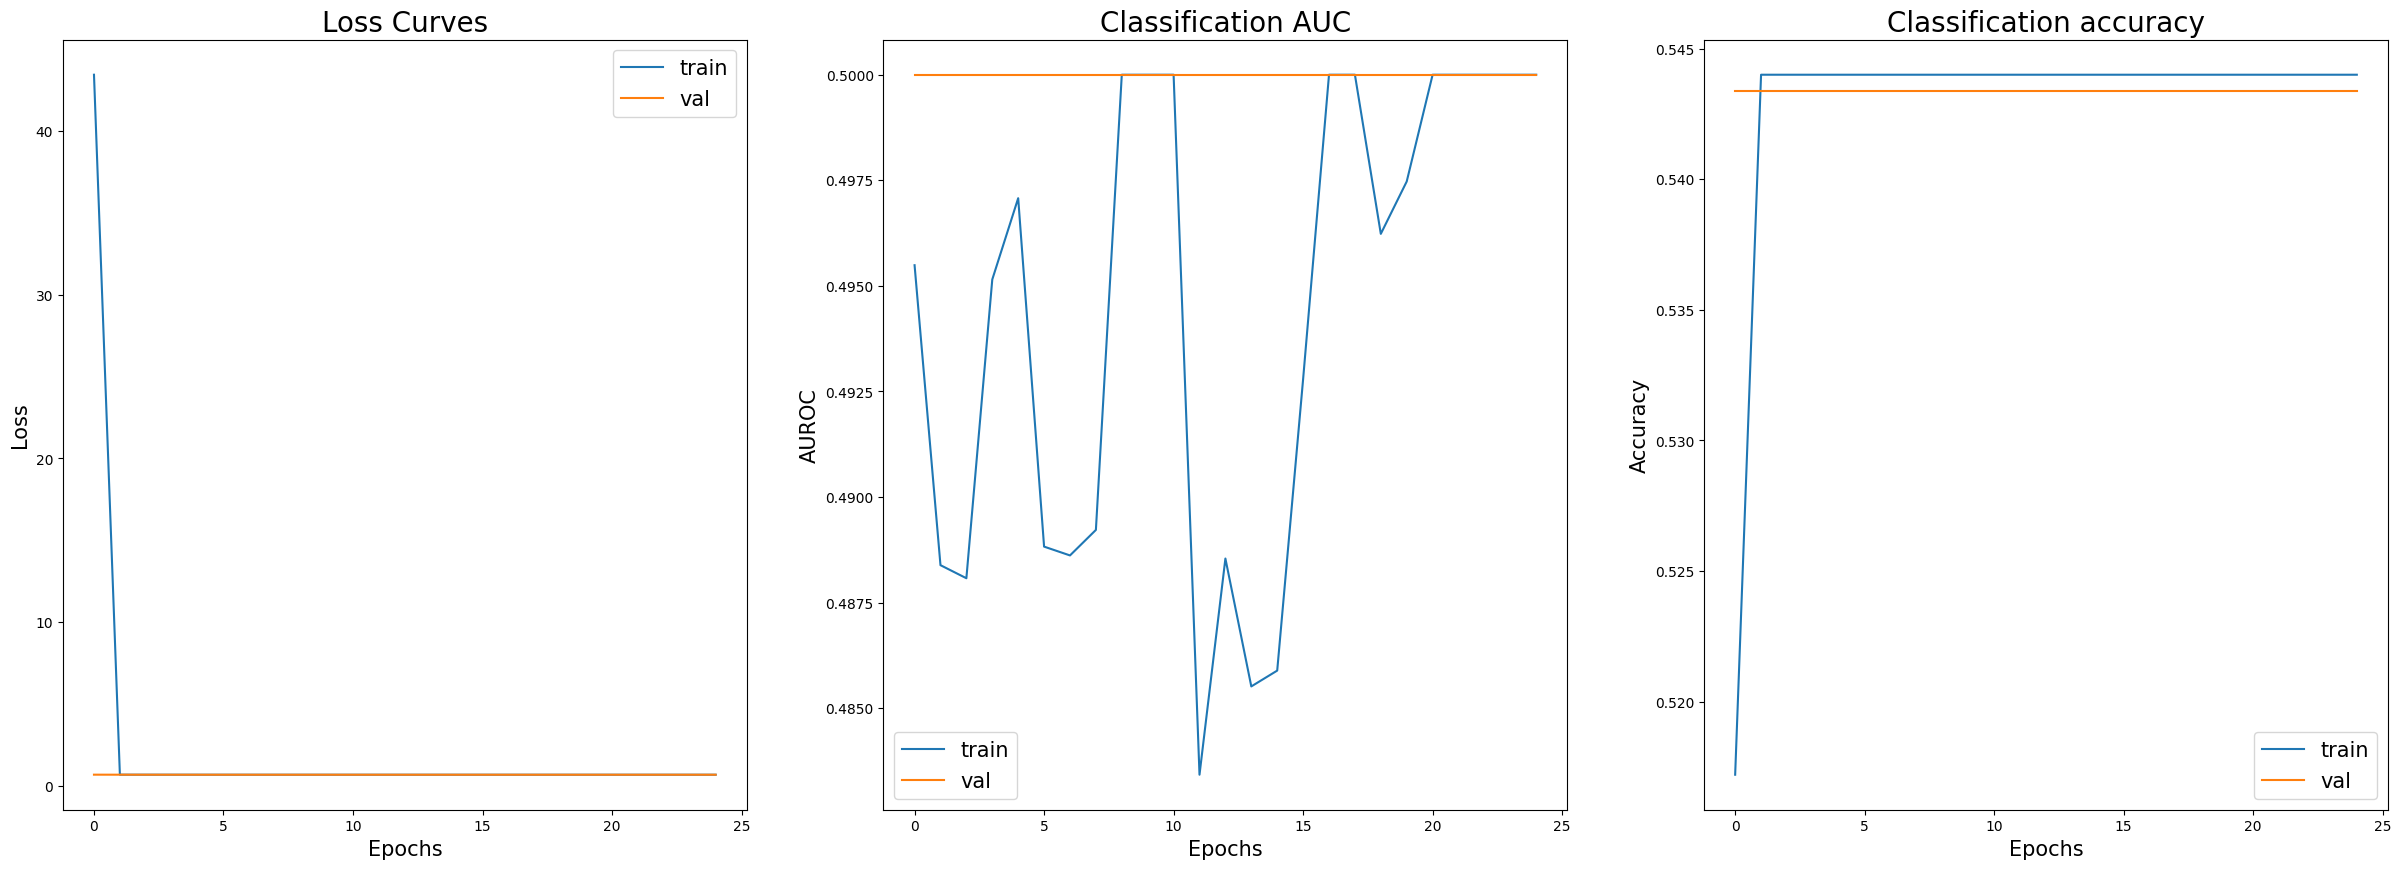

In [66]:
summarize_diagnostics(history)


In [67]:
testLoss, testAcc, testAUC = model.evaluate(test_ds, verbose=1)
print('Test loss:{:0.5f}'.format(testLoss))
print('Test accuracy:{:0.4f}'.format(testAcc))
print('Test AUC:{:0.4f}'.format(testAUC))

27/27 [==============================] - 2s 57ms/step - loss: 0.6893 - accuracy: 0.5438 - auc: 0.5000
Test loss:0.68930
Test accuracy:0.5438
Test AUC:0.5000


In [68]:
# 4rd
input_size = (128, 128, 1)

learning_rate = 0.001
dropout_rate = 0.5
filter_size = 15
kernel_size_1 = (3, 3)
kernel_size_2 = (5, 5)

up_sampling_1= (2, 2)
up_sampling_2= (2, 2)

pool_size_1= (6, 6)
pool_size_2= (6, 6)
# Create a Sequential model
model = keras.Sequential()

model.add(layers.Conv2D( filter_size, kernel_size = kernel_size_1, activation='relu', padding = 'valid', input_shape = input_size))
model.add(layers.MaxPooling2D(pool_size = pool_size_1 ))

model.add(layers.Conv2D( filter_size, kernel_size = kernel_size_2, activation='relu', padding = 'same', input_shape = input_size))
model.add(layers.MaxPooling2D(pool_size = pool_size_2 ))


model.add(layers.UpSampling2D(size=up_sampling_1)) # Upsample the feature maps
model.add(layers.UpSampling2D(size=up_sampling_1))

model.add(layers.Dropout(dropout_rate))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification, so using sigmoid activation
print(model.summary())

# Compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy',auc])



Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 126, 126, 15)      150       
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 21, 21, 15)        0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 21, 21, 15)        5640      
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 3, 3, 15)          0         
 ng2D)                                                           
                                                                 
 up_sampling2d_10 (UpSampli  (None, 6, 6, 15)          0         
 ng2D)                                                           
                                                     

In [69]:
# early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10,
                   restore_best_weights=True)
history = model.fit(train_ds,
                        epochs=25,
                        batch_size=64,
                        validation_data=val_ds,
                        verbose=1,
                        callbacks=[es])

Epoch 1/25
124/124 [==============================] - 15s 100ms/step - loss: 3.7523 - accuracy: 0.5218 - auc: 0.4873 - val_loss: 0.6965 - val_accuracy: 0.5351 - val_auc: 0.4765
Epoch 2/25
124/124 [==============================] - 13s 98ms/step - loss: 0.7031 - accuracy: 0.5420 - auc: 0.4868 - val_loss: 0.6900 - val_accuracy: 0.5351 - val_auc: 0.5265
Epoch 3/25
124/124 [==============================] - 13s 98ms/step - loss: 0.6923 - accuracy: 0.5468 - auc: 0.4990 - val_loss: 0.6879 - val_accuracy: 0.5398 - val_auc: 0.5230
Epoch 4/25
124/124 [==============================] - 13s 102ms/step - loss: 0.6879 - accuracy: 0.5567 - auc: 0.5017 - val_loss: 0.6904 - val_accuracy: 0.5351 - val_auc: 0.5230
Epoch 5/25
124/124 [==============================] - 14s 106ms/step - loss: 0.6853 - accuracy: 0.5526 - auc: 0.5088 - val_loss: 0.6888 - val_accuracy: 0.5375 - val_auc: 0.5214
Epoch 6/25
124/124 [==============================] - 14s 107ms/step - loss: 0.6838 - accuracy: 0.5574 - auc: 0.5171 

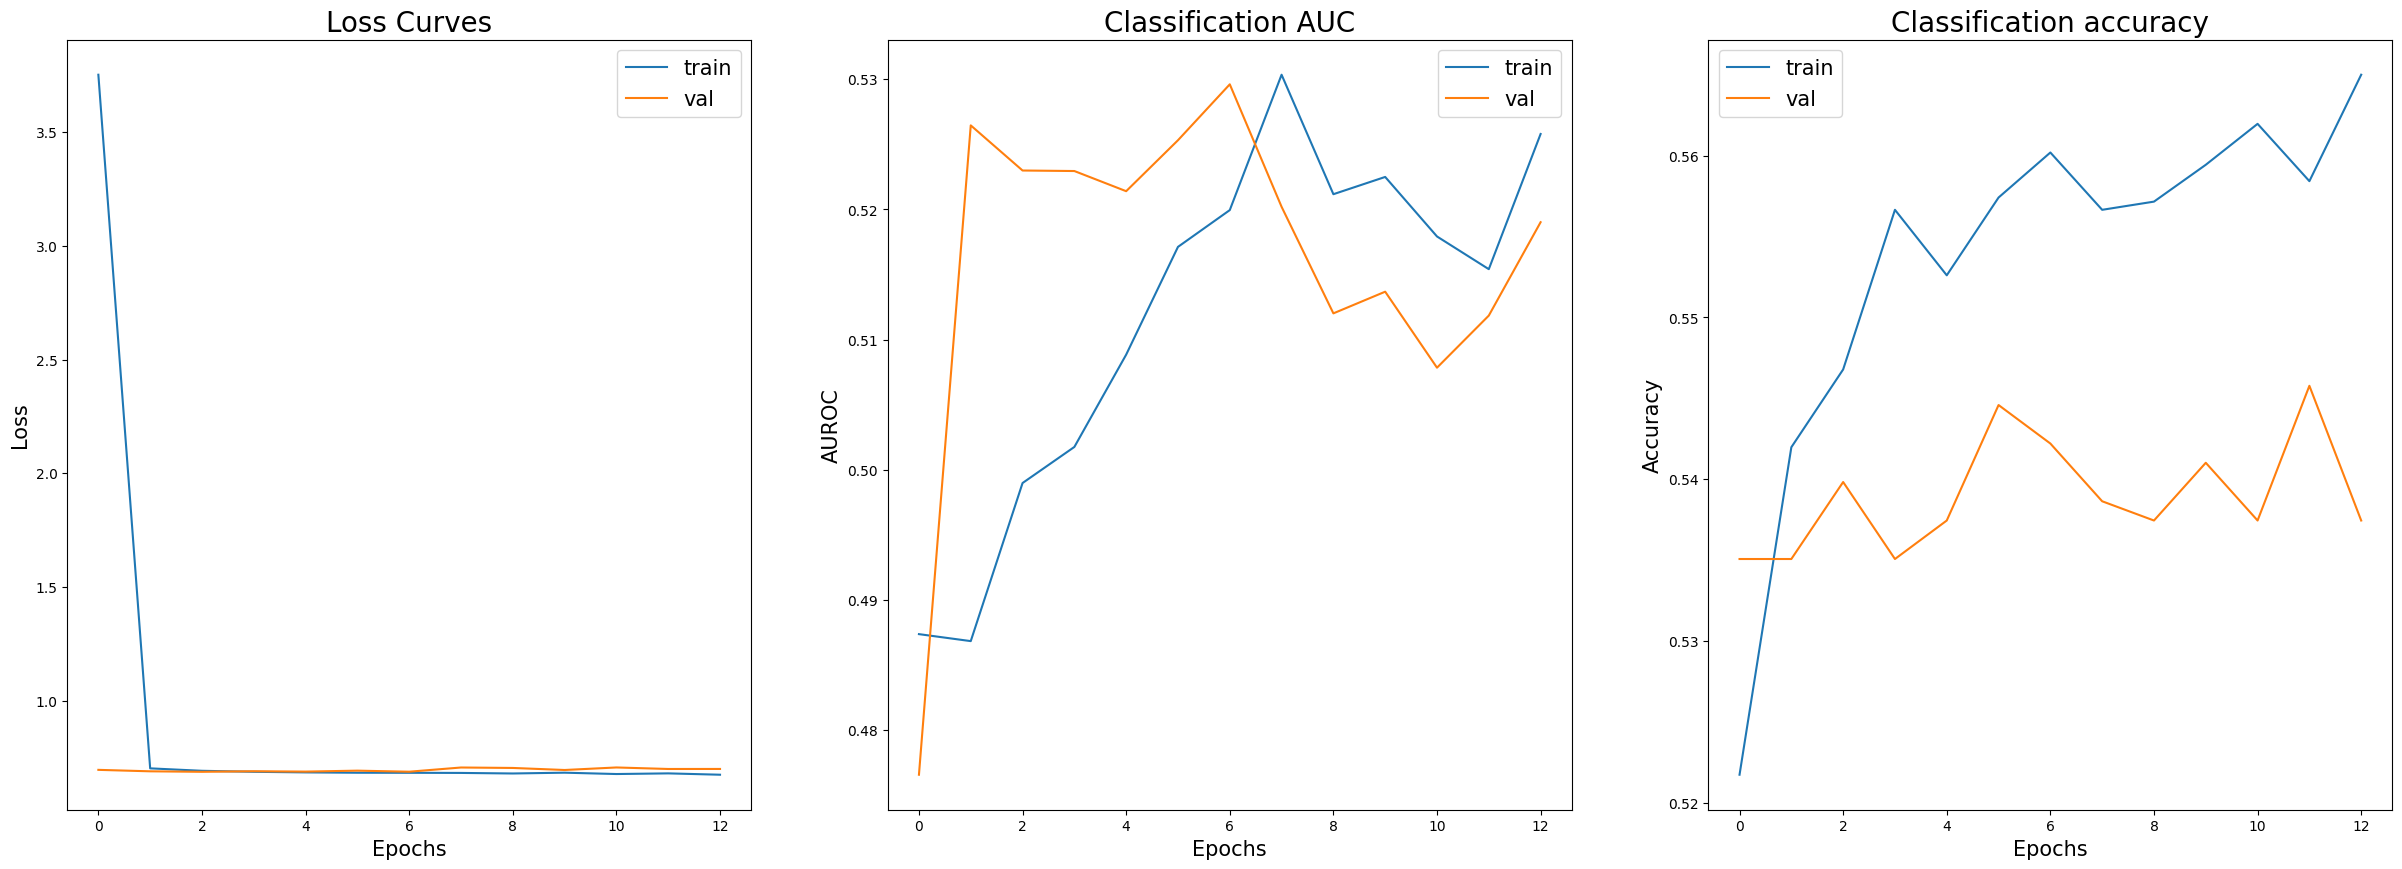

In [70]:
summarize_diagnostics(history)


In [71]:
testLoss, testAcc, testAUC = model.evaluate(test_ds, verbose=1)
print('Test loss:{:0.5f}'.format(testLoss))
print('Test accuracy:{:0.4f}'.format(testAcc))
print('Test AUC:{:0.4f}'.format(testAUC))

27/27 [==============================] - 3s 64ms/step - loss: 0.6884 - accuracy: 0.5474 - auc: 0.5178
Test loss:0.68835
Test accuracy:0.5474
Test AUC:0.5178


In [72]:
# 5rd
input_size = (128, 128, 1)

learning_rate = 0.001
dropout_rate = 0.5
filter_size = 15
kernel_size_1 = (3, 3)
kernel_size_2 = (5, 5)

up_sampling_1= (2, 2)
up_sampling_2= (2, 2)

pool_size_1= (7, 7)
pool_size_2= (7, 7)


# Create a Sequential model
model = keras.Sequential()

model.add(layers.Conv2D( filter_size, kernel_size = kernel_size_1, activation='relu', padding = 'valid', input_shape = input_size))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D( filter_size, kernel_size = kernel_size_2, activation='relu', padding = 'same', input_shape = input_size))
model.add(layers.MaxPooling2D(pool_size=(3, 3)))


model.add(layers.UpSampling2D(size=up_sampling_1)) # Upsample the feature maps
model.add(layers.UpSampling2D(size=up_sampling_1))

model.add(layers.Dropout(dropout_rate))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification, so using sigmoid activation
print(model.summary())

# Compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy',auc])



Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 126, 126, 15)      150       
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 63, 63, 15)        0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 63, 63, 15)        5640      
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 21, 21, 15)        0         
 ng2D)                                                           
                                                                 
 up_sampling2d_12 (UpSampli  (None, 42, 42, 15)        0         
 ng2D)                                                           
                                                     

In [73]:
# early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10,
                   restore_best_weights=True)
history = model.fit(train_ds,
                        epochs=25,
                        batch_size=64,
                        validation_data=val_ds,
                        verbose=1,
                        callbacks=[es])

Epoch 1/25
124/124 [==============================] - 15s 103ms/step - loss: 120.4108 - accuracy: 0.5233 - auc: 0.5171 - val_loss: 0.7571 - val_accuracy: 0.5422 - val_auc: 0.5037
Epoch 2/25
124/124 [==============================] - 13s 101ms/step - loss: 0.7033 - accuracy: 0.5847 - auc: 0.6085 - val_loss: 0.7476 - val_accuracy: 0.5553 - val_auc: 0.5135
Epoch 3/25
124/124 [==============================] - 13s 100ms/step - loss: 0.6847 - accuracy: 0.6050 - auc: 0.6343 - val_loss: 0.7366 - val_accuracy: 0.5648 - val_auc: 0.5373
Epoch 4/25
124/124 [==============================] - 13s 98ms/step - loss: 0.6337 - accuracy: 0.6376 - auc: 0.6859 - val_loss: 0.7594 - val_accuracy: 0.5375 - val_auc: 0.5203
Epoch 5/25
124/124 [==============================] - 13s 96ms/step - loss: 0.6021 - accuracy: 0.6560 - auc: 0.7203 - val_loss: 0.7795 - val_accuracy: 0.5208 - val_auc: 0.5310
Epoch 6/25
124/124 [==============================] - 13s 97ms/step - loss: 0.5615 - accuracy: 0.6912 - auc: 0.7672

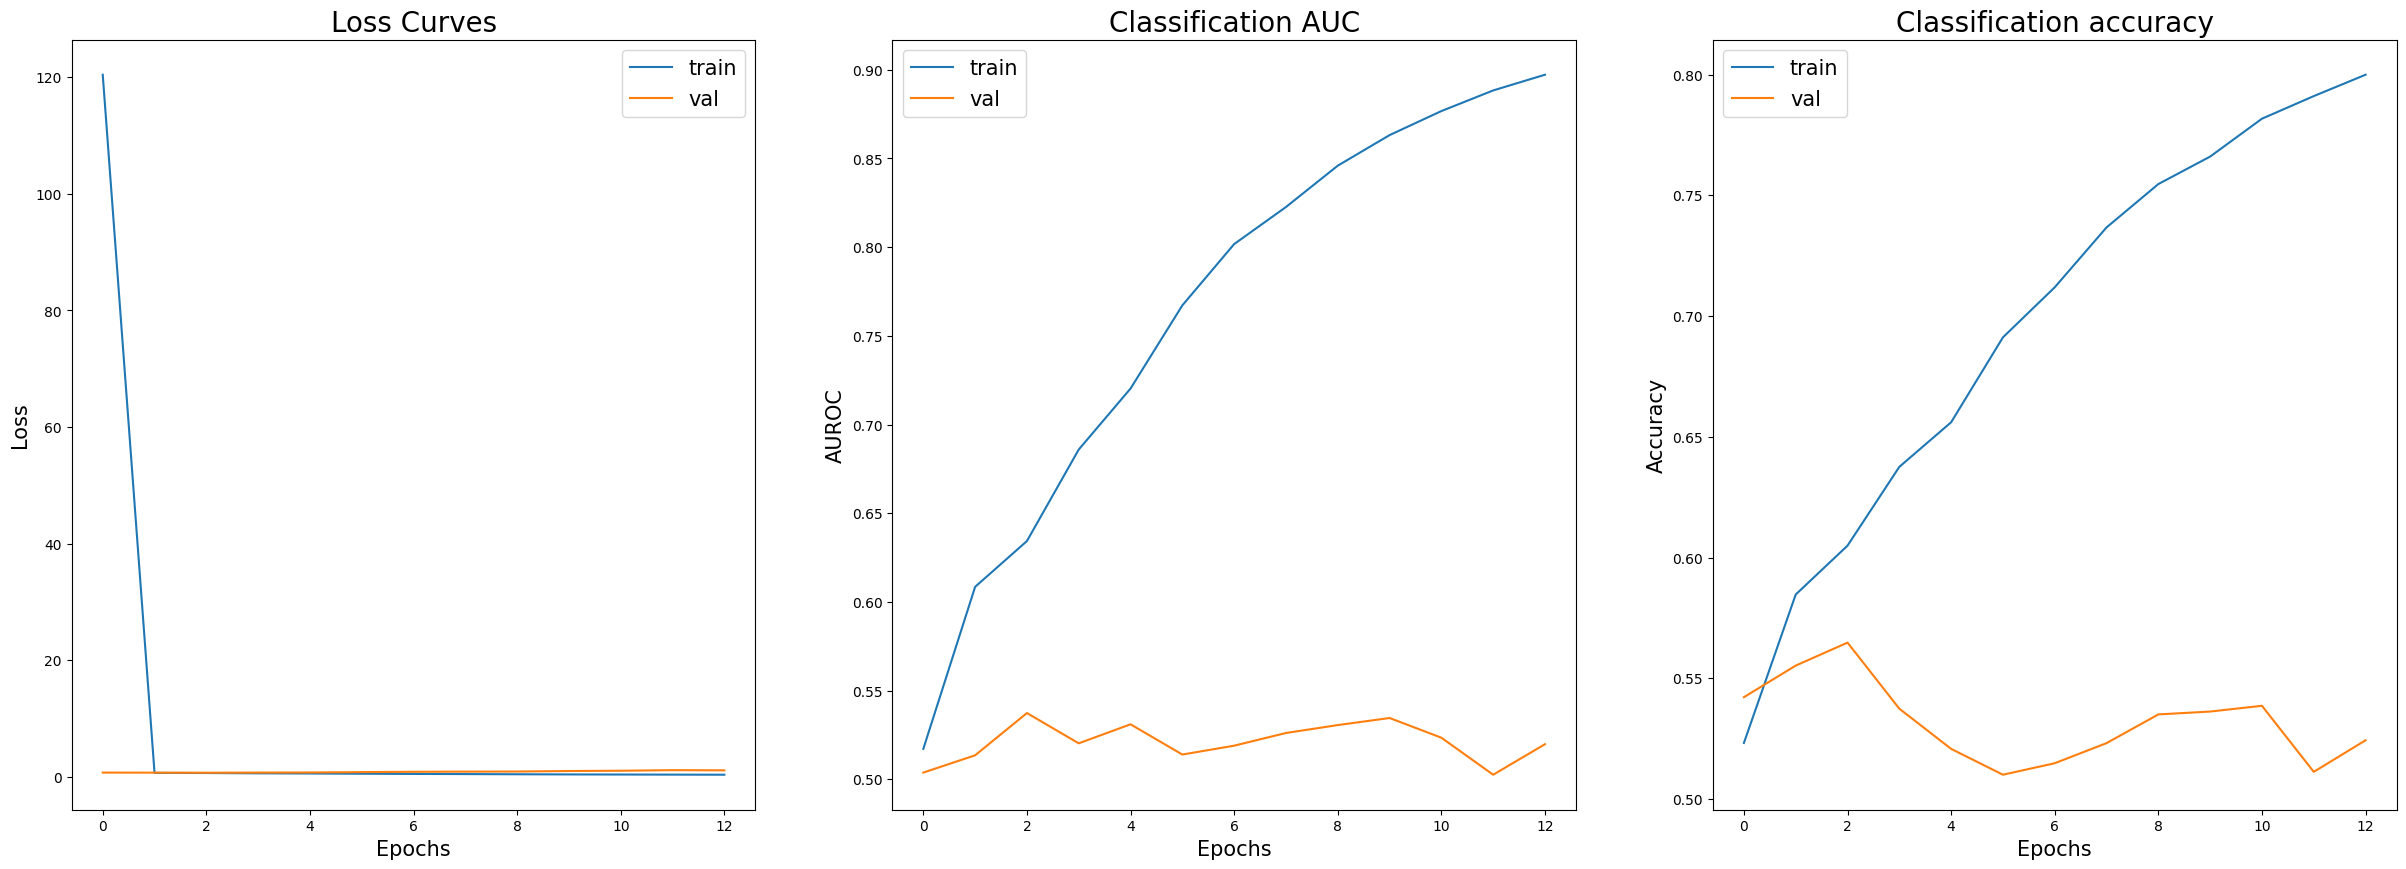

In [74]:
summarize_diagnostics(history)


In [75]:
testLoss, testAcc, testAUC = model.evaluate(test_ds, verbose=1)
print('Test loss:{:0.5f}'.format(testLoss))
print('Test accuracy:{:0.4f}'.format(testAcc))
print('Test AUC:{:0.4f}'.format(testAUC))

27/27 [==============================] - 2s 58ms/step - loss: 0.8106 - accuracy: 0.5130 - auc: 0.5072
Test loss:0.81055
Test accuracy:0.5130
Test AUC:0.5072


# Transfer learning

In [6]:
# loading data with rbg mode

data_dir = '/content/drive/MyDrive/split_archive/'
train_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'train'),
                                                       label_mode='int',
                                                       seed=rng.integers(500000),
                                                       image_size=(128,128),
                                                       color_mode='rgb',
                                                       batch_size=64)

val_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'val'),
                                                    label_mode='int',
                                                     seed=rng.integers(500000),
                                                     image_size=(128,128),
                                                     color_mode='rgb',
                                                     batch_size=64)

test_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'test'),
                                                    label_mode='int',
                                                      seed=rng.integers(500000),
                                                      image_size=(128,128),
                                                      color_mode='rgb',
                                                      batch_size=64)

Found 3954 files belonging to 2 classes.
Found 841 files belonging to 2 classes.
Found 844 files belonging to 2 classes.


In [7]:
# Load pre-trained model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_shape=(128,128,3),
   # input_shape=None,
   # pooling=None,
   # classes=1000,
  # classifier_activation='softmax',
   # include_preprocessing=True
)

In [9]:
#  make base_model non-trainable
base_model.trainable = False

In [10]:
# Creating model
inputs = Input(shape=(128,128,3))
layer = base_model(inputs, training=False)       # base_model is running in inference mode here, i.e., extracting features using the trained model.
layer = GlobalAveragePooling2D()(layer)          # Global average pooling


outputs = Dense(1, activation='softmax')(layer)  # A Dense classifier with a single unit (binary classification)
model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetv2-s (Function  (None, 4, 4, 1280)        20331360  
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 20332641 (77.56 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 20331360 (77.56 MB)
_________________________________________________________________


In [8]:
# early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10,
                   restore_best_weights=True)

# define optimizer
opt = Adam(learning_rate=0.000001)

# Compile
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', auc])

In [9]:
# fit model
history = model.fit(train_ds,
                       epochs=50,
                       batch_size=16,
                       validation_data=val_ds,
                       verbose=1,
                       callbacks=[es])

Epoch 1/50
62/62 [==============================] - 261s 3s/step - loss: 0.7062 - accuracy: 0.4560 - auc: 0.5000 - val_loss: 0.7029 - val_accuracy: 0.4566 - val_auc: 0.5000
Epoch 2/50
62/62 [==============================] - 15s 216ms/step - loss: 0.7054 - accuracy: 0.4560 - auc: 0.5000 - val_loss: 0.7021 - val_accuracy: 0.4566 - val_auc: 0.5000
Epoch 3/50
62/62 [==============================] - 15s 215ms/step - loss: 0.7047 - accuracy: 0.4560 - auc: 0.5000 - val_loss: 0.7014 - val_accuracy: 0.4566 - val_auc: 0.5000
Epoch 4/50
62/62 [==============================] - 15s 218ms/step - loss: 0.7040 - accuracy: 0.4560 - auc: 0.5000 - val_loss: 0.7008 - val_accuracy: 0.4566 - val_auc: 0.5000
Epoch 5/50
62/62 [==============================] - 15s 217ms/step - loss: 0.7033 - accuracy: 0.4560 - auc: 0.5000 - val_loss: 0.7001 - val_accuracy: 0.4566 - val_auc: 0.5000
Epoch 6/50
62/62 [==============================] - 15s 216ms/step - loss: 0.7027 - accuracy: 0.4560 - auc: 0.5000 - val_loss: 

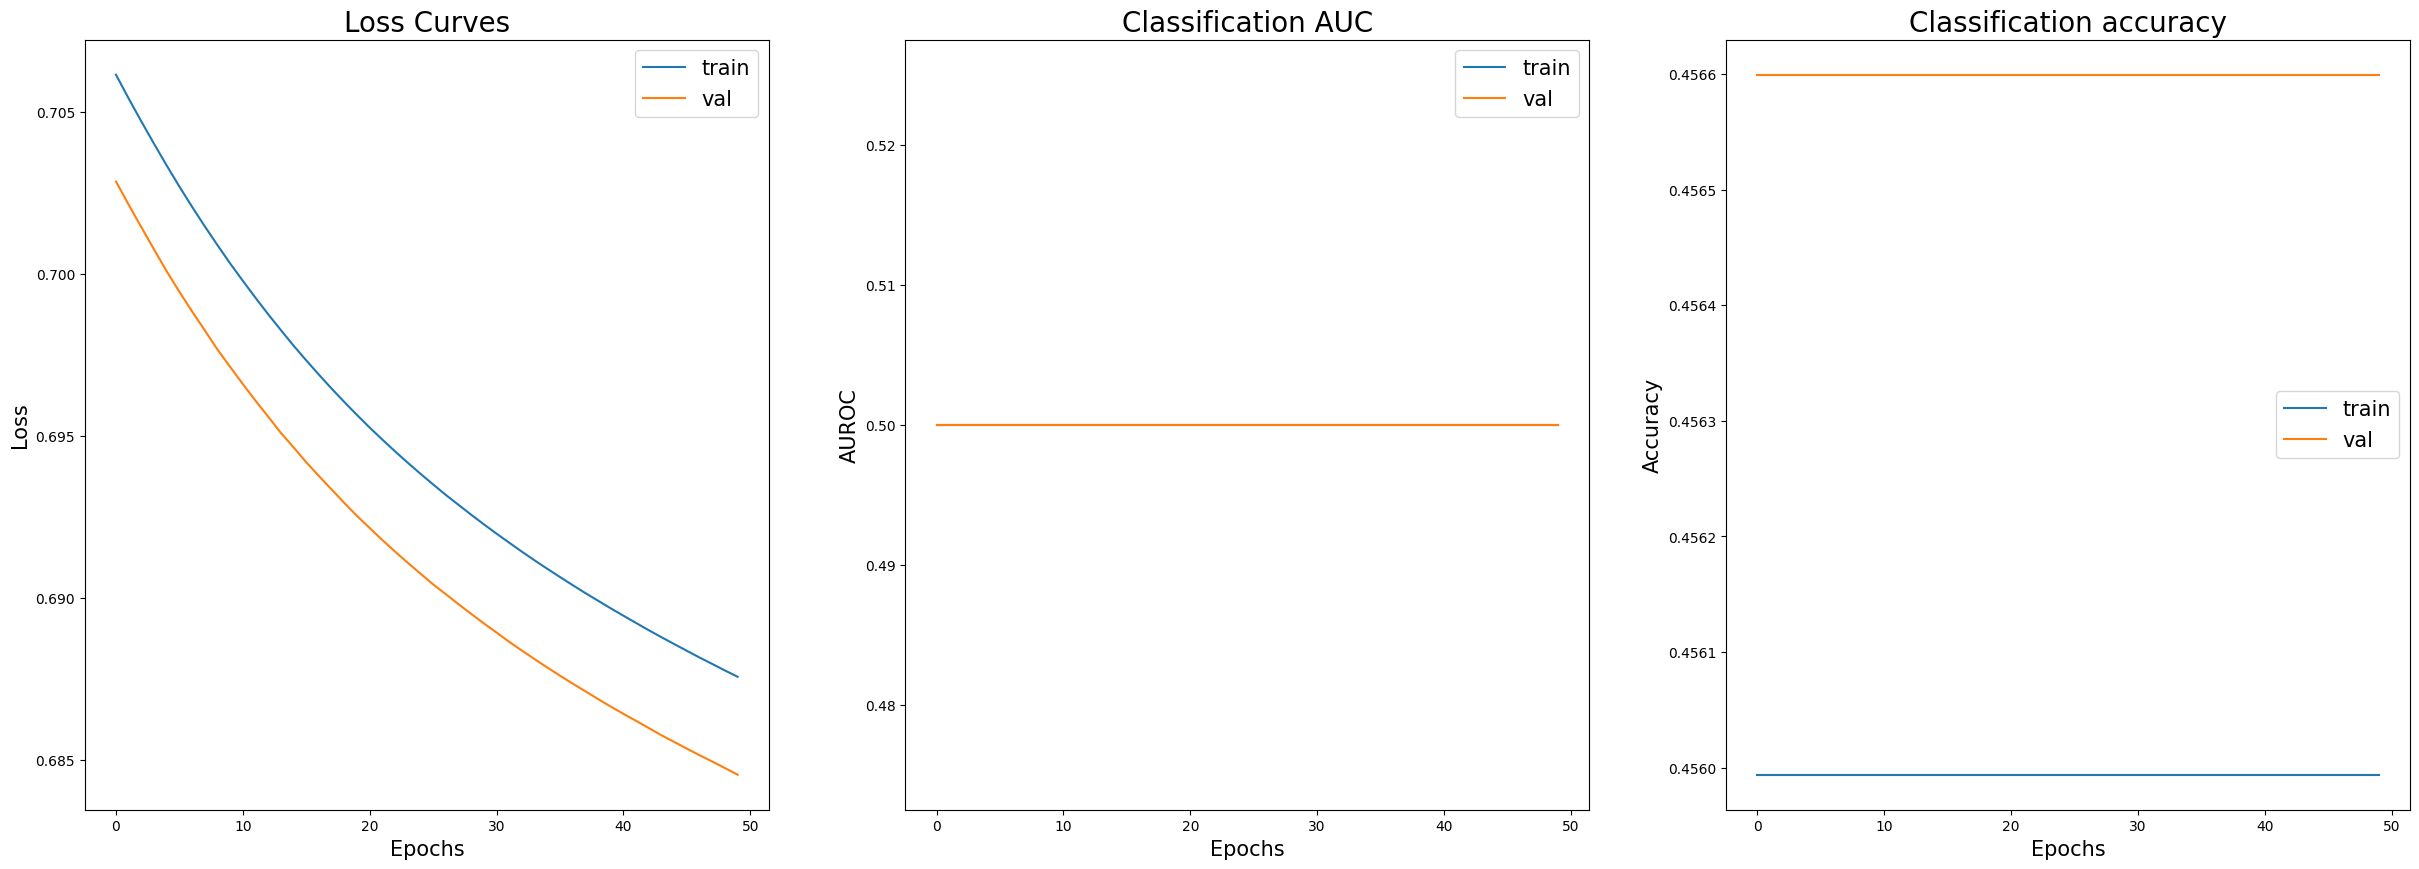

In [10]:
# loss curves & accuracy
summarize_diagnostics(history)

In [11]:
testLoss, testAcc, testAUC = model.evaluate(test_ds, verbose=1)
print('Test loss:{:0.5f}'.format(testLoss))
print('Test accuracy:{:0.4f}'.format(testAcc))
print('Test AUC:{:0.4f}'.format(testAUC))

14/14 [==============================] - 43s 1s/step - loss: 0.6936 - accuracy: 0.4562 - auc: 0.5000
Test loss:0.69364
Test accuracy:0.4562
Test AUC:0.5000


In [11]:
# Make the base model trainable now
base_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetv2-s (Function  (None, 4, 4, 1280)        20331360  
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 20332641 (77.56 MB)
Trainable params: 20178769 (76.98 MB)
Non-trainable params: 153872 (601.06 KB)
_________________________________________________________________


In [12]:
# early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10,
                   restore_best_weights=True)

# define optimizer
opt = Adam(learning_rate=0.000001)

# Compile
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', auc])

In [13]:
# fit model
history = model.fit(train_ds,
                       epochs=50,
                       batch_size=16,
                       validation_data=val_ds,
                       verbose=1,
                       callbacks=[es])

Epoch 1/50
62/62 [==============================] - 100s 314ms/step - loss: 0.6868 - accuracy: 0.4560 - auc: 0.5000 - val_loss: 0.6698 - val_accuracy: 0.4566 - val_auc: 0.5000
Epoch 2/50
62/62 [==============================] - 16s 240ms/step - loss: 0.6689 - accuracy: 0.4560 - auc: 0.5000 - val_loss: 0.6587 - val_accuracy: 0.4566 - val_auc: 0.5000
Epoch 3/50
62/62 [==============================] - 16s 240ms/step - loss: 0.6567 - accuracy: 0.4560 - auc: 0.5000 - val_loss: 0.6502 - val_accuracy: 0.4566 - val_auc: 0.5000
Epoch 4/50
62/62 [==============================] - 17s 241ms/step - loss: 0.6464 - accuracy: 0.4560 - auc: 0.5000 - val_loss: 0.6436 - val_accuracy: 0.4566 - val_auc: 0.5000
Epoch 5/50
62/62 [==============================] - 16s 236ms/step - loss: 0.6374 - accuracy: 0.4560 - auc: 0.5000 - val_loss: 0.6379 - val_accuracy: 0.4566 - val_auc: 0.5000
Epoch 6/50
62/62 [==============================] - 16s 239ms/step - loss: 0.6295 - accuracy: 0.4560 - auc: 0.5000 - val_los

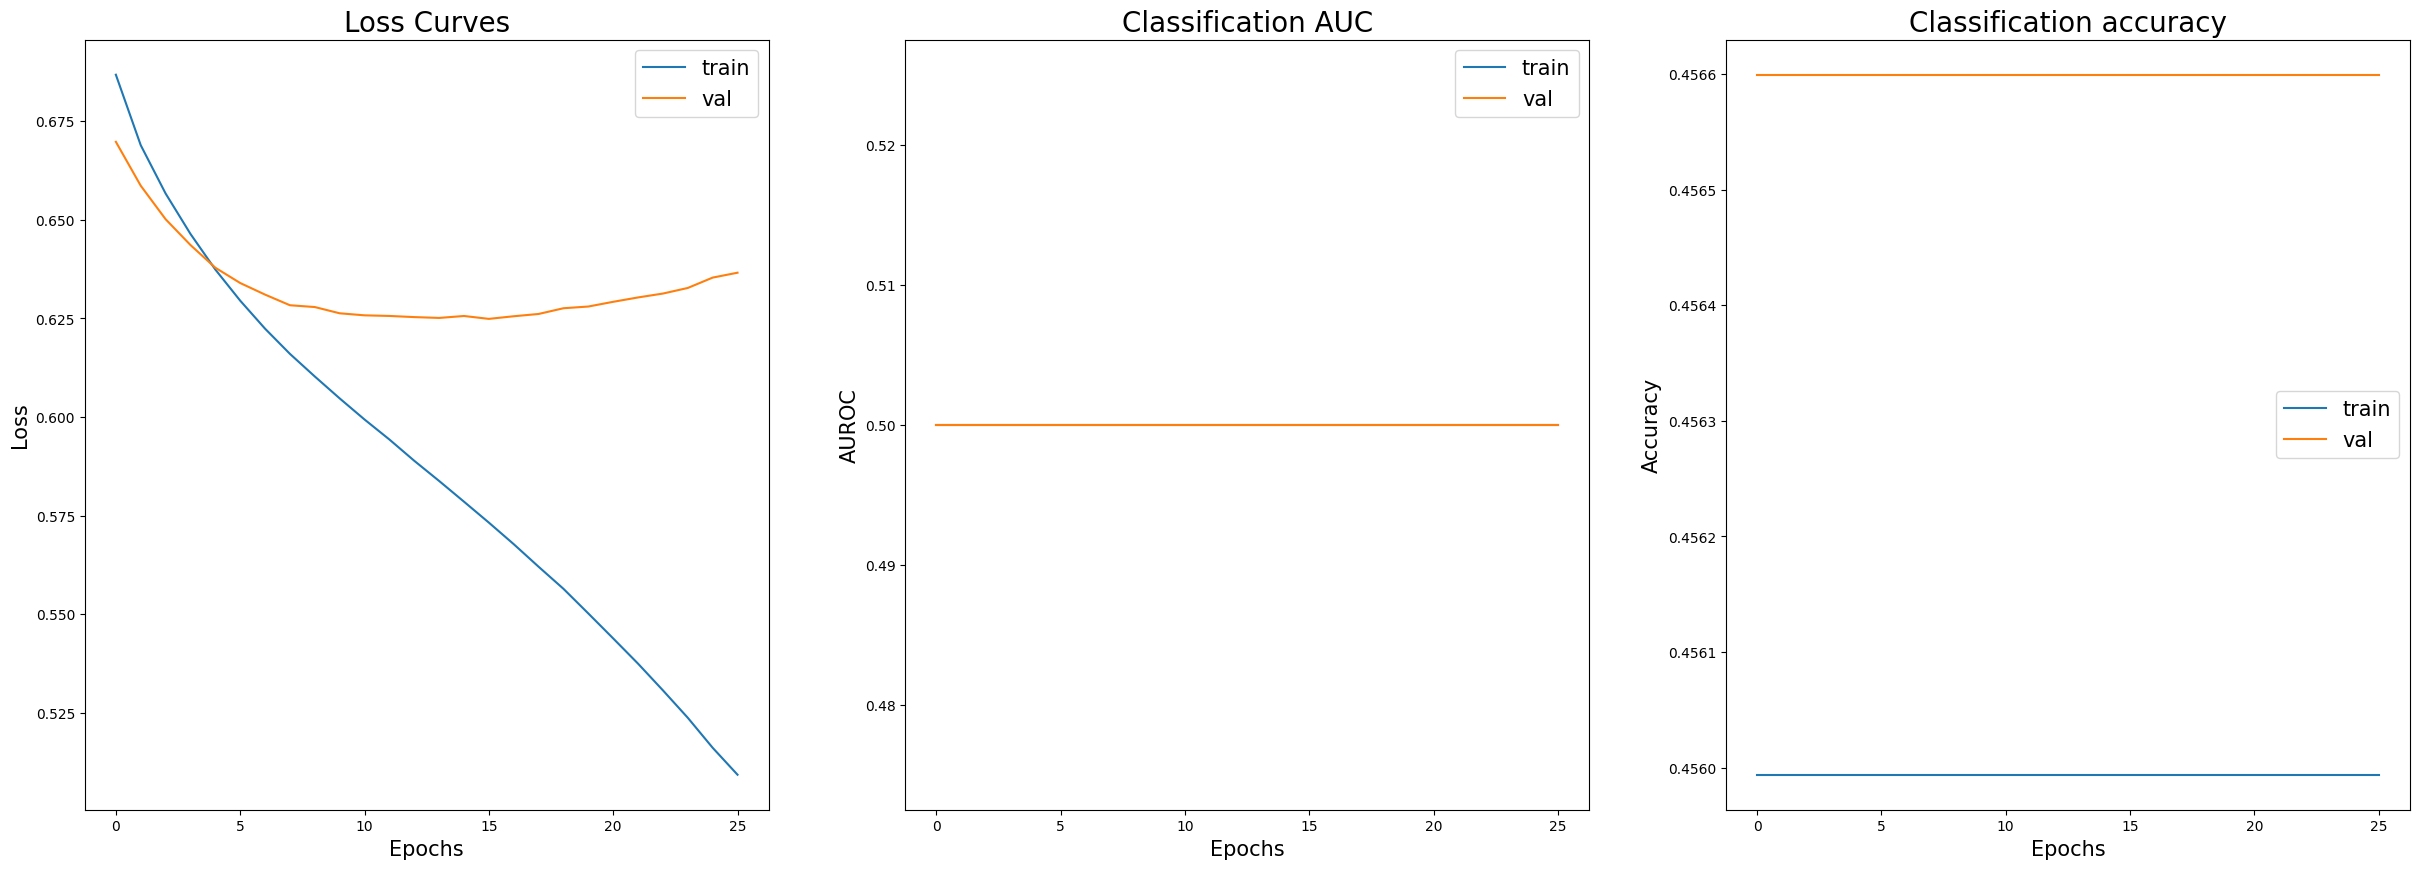

In [14]:
# loss curves & accuracy
summarize_diagnostics(history)

In [16]:
testLoss, testAcc, testAUC = model.evaluate(test_ds, verbose=1)
print('Test loss:{:0.5f}'.format(testLoss))
print('Test accuracy:{:0.4f}'.format(testAcc))
print('Test AUC:{:0.4f}'.format(testAUC))

14/14 [==============================] - 3s 91ms/step - loss: 0.6275 - accuracy: 0.4562 - auc: 0.5000
Test loss:0.62746
Test accuracy:0.4562
Test AUC:0.5000
